# Project overview

* This project is about building a classifier that predicts whether a loaner will default on his loan


* The model should minimize as much as possible to risk to grant credit to a loaner that will default 


* Since the target is binary it is a supervised binary classification task



In [1]:
import warnings
warnings.filterwarnings('once')

## Aggregating data

* The data is composed of several tables

* We will aggregate using a Kaggle kernel

* The principles are aggreation are for each table: 
    * one-hot encode cateogorical features
    * average by mean
    * create one column that counts the occurrences of each key
    * merge with appropriate table
    
* We will import the aggregation function from a script
    

In [2]:
import pandas as pd
from aggregate_tables import build_model_input
import re
data, _ , target = build_model_input()

### To prevent errors with LGBM classifier
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data and test
Shapes :  (307511, 122) (48744, 121)


## Shape

In [3]:
print('The data has ' + str(data.shape[0]) + ' lines and ' + str(data.shape[1]) + ' columns')

The data has 307511 lines and 504 columns


## Duplicates

In [4]:
print('There are ' + str(sum(data.duplicated(subset = 'SK_ID_CURR'))) + ' duplicated IDs')
data.set_index('SK_ID_CURR', inplace = True)

There are 0 duplicated IDs


In [5]:
data.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
SK_ID_CURR                                                                
100002                 0          202500.0      406597.5        24700.5   
100003                 0          270000.0     1293502.5        35698.5   
100004                 0           67500.0      135000.0         6750.0   
100006                 0          135000.0      312682.5        29686.5   
100007                 0          121500.0      513000.0        21865.5   

            AMT_GOODS_PRICE_x  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                              
100002               351000.0                    0.018801       -9461   
100003              1129500.0                    0.003541      -16765   
100004               135000.0                    0.010032      -19046   
100006               297000.0                    0.008019      -19005   
100007               513000.0                    0.028663      -19932   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
SK_ID_CURR                                                     ...   
100002               -637            -3648.0            -2120  ...   
100003              -1188            -1186.0             -291  ...   
100004               -225            -4260.0            -2531  ...   
100006              -3039            -9833.0            -2437  ...   
100007              -3038            -4311.0            -3458  ...   

            cc_bal_cc_bal_status__Refused  cc_bal_cc_bal_status__Sentproposal  \
SK_ID_CURR                                                                      
100002                                NaN                                 NaN   
100003                                NaN                                 NaN   
100004                                NaN                                 NaN   
100006                                0.0                                 0.0   
100007                                NaN                                 NaN   

            cc_bal_cc_bal_status__Signed  inst_SK_ID_PREV  \
SK_ID_CURR                                                  
100002                               NaN             19.0   
100003                               NaN             25.0   
100004                               NaN              3.0   
100006                               0.0             16.0   
100007                               NaN             66.0   

            inst_NUM_INSTALMENT_VERSION  inst_NUM_INSTALMENT_NUMBER  \
SK_ID_CURR                                                            
100002                         1.052632                   10.000000   
100003                         1.040000                    5.080000   
100004                         1.333333                    2.000000   
100006                         1.125000                    4.437500   
100007                         1.166667                    7.045455   

            inst_DAYS_INSTALMENT  inst_DAYS_ENTRY_PAYMENT  \
SK_ID_CURR                                                  
100002               -295.000000              -315.421053   
100003              -1378.160000             -1385.320000   
100004               -754.000000              -761.666667   
100006               -252.250000              -271.625000   
100007              -1028.606061             -1032.242424   

            inst_AMT_INSTALMENT  inst_AMT_PAYMENT  
SK_ID_CURR                                         
100002             11559.247105      11559.247105  
100003             64754.586000      64754.586000  
100004              7096.155000       7096.155000  
100006             62947.088438      62947.088438  
100007             12666.444545      12214.060227  

[5 rows x 503 columns]

## Missing values

In [6]:
print('The ratio of Nans is ' + str(data.isnull().mean().mean().round(decimals = 2)))

The ratio of Nans is 0.15


There are only 15% of missing values in the table, which is a good working basis.

## Target

Since we will predict a target, we should check first whether there are Nans on the target 

In [7]:
print('There are ' + str(sum(target.isnull())) + ' missing values on the target')

There are 0 missing values on the target


We will check the distribution of the target

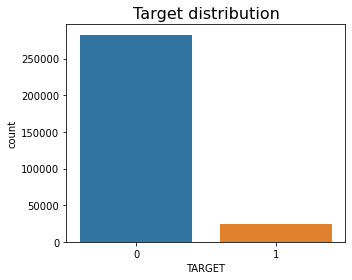

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def target_distrib():
    
    fig = plt.figure(figsize = (5,4))
    g = fig.add_subplot(111)
    g = sns.countplot(x = 'TARGET', data = pd.DataFrame(target))
    g.set_title('Target distribution', fontsize = 16)
    
target_distrib()

* The distribution of the target is strongly unbalanced


* We will consider oversampling in the workflow to train the estimators on a balanced dataset

* Risk of training on unbalanced targets is to produce bias and poorly predict the minority class

* Aside the common test set, we will separate a validation dataset that will evaluate estimators trained on augmented data

## Splits

###  Train/test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, stratify = target, 
                                   test_size = 0.2, random_state = 42)

### Train/validation  

In [10]:
data, x_valid, target, y_valid = train_test_split(X_train, y_train, stratify = y_train, 
                                   test_size = 0.2, random_state = 42)

Since the data is large enough and to speed up the calculations, we will keep 10% of the rows of the remaining data for the train set 

### Subset of the data : 10%  of the samples

In [11]:
data, _, target, __ = train_test_split(data, target, stratify = target, 
                                   test_size = 0.9, random_state = 42)

## Feature selection

* Given the high dimensionality of the data (504 features), we will implement the feature selector class built by Will Koehrsen and hosted on GitHub. This will the reduce its dimension based on principles : 
    * percentage of Nans superior to a specified threshold (we'll take 60%)
    * zero variance
    * absolute Pearson correlation superior to 0.98 (redundancy)
    * zero or minimal feature importance in trained LGBM Classifier (the feature does not contribute to 99% of the cumulative feature importances)
    

### Univariate

#### NANs

In [12]:
from Feature_selector import FeatureSelector
# Initializing feature selector

fs = FeatureSelector(data = data, labels = target)

fs.identify_missing(missing_threshold = 0.6)

57 features with greater than 0.60 missing values.



In [13]:
fs.missing_stats.head()

missing_fraction
RATE_INTEREST_PRIVILEGED                   0.983689
RATE_INTEREST_PRIMARY                      0.983689
cc_bal_AMT_PAYMENT_CURRENT                 0.802185
cc_bal_AMT_DRAWINGS_OTHER_CURRENT          0.801626
cc_bal_AMT_DRAWINGS_POS_CURRENT            0.801626

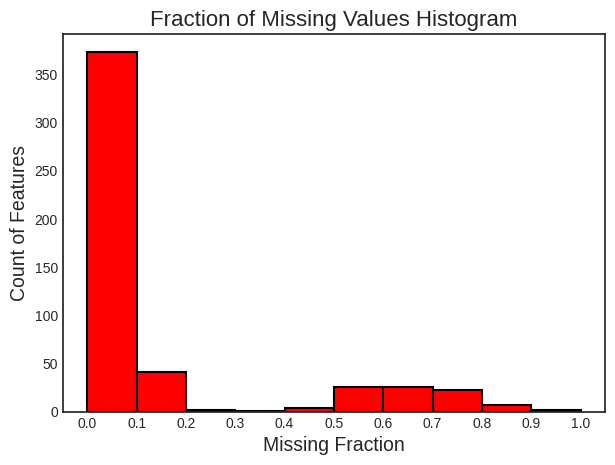

In [14]:
fs.plot_missing()

#### Zero variance

In [15]:
fs.identify_single_unique()

20 features with a single unique value.



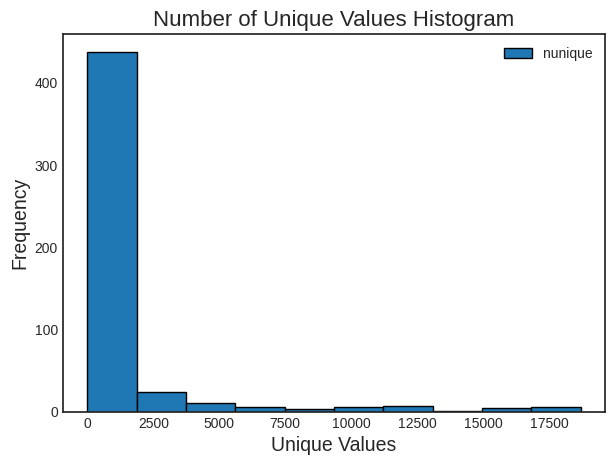

In [16]:
fs.plot_unique()

### Pearson correlation

In [17]:
fs.identify_collinear(correlation_threshold = 0.98)

40 features with a correlation magnitude greater than 0.98.



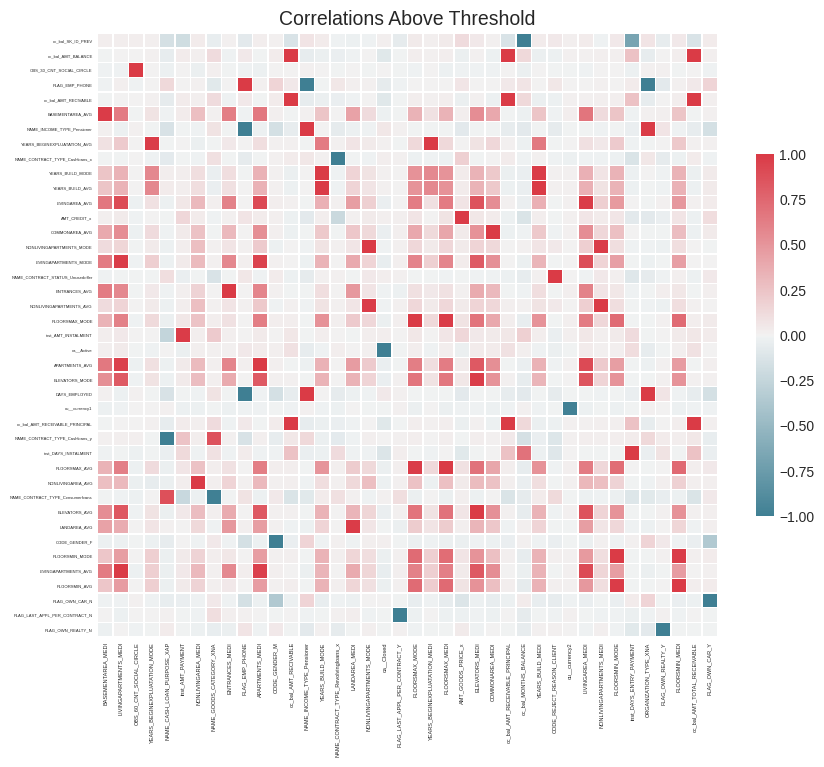

In [18]:
fs.plot_collinear()

In [19]:
fs.record_collinear.head()

drop_feature                 corr_feature  corr_value
0             AMT_GOODS_PRICE_x                 AMT_CREDIT_x    0.987000
1                FLAG_EMP_PHONE                DAYS_EMPLOYED   -0.999712
2  YEARS_BEGINEXPLUATATION_MODE  YEARS_BEGINEXPLUATATION_AVG    0.983976
3              YEARS_BUILD_MODE              YEARS_BUILD_AVG    0.990409
4                FLOORSMAX_MODE                FLOORSMAX_AVG    0.985326

In [20]:
### Removing features from previous principles

collinear_features = fs.ops['collinear']
missing_features = fs.ops['missing']
variance_features = fs.ops['single_unique']

features_to_remove = collinear_features + missing_features + variance_features

features_to_remove =  list(set(features_to_remove))

data_v2 = data.drop(features_to_remove, axis = 1)

data_v2.shape

(19680, 399)

### Feature importance

In [21]:
fs = FeatureSelector(data = data_v2, labels = target)


fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.72268	valid_0's binary_logloss: 0.257472
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.710688	valid_0's binary_logloss: 0.257978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	valid_0's auc: 0.755426	valid_0's binary_logloss: 0.250043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's auc: 0.716631	valid_0's binary_logloss: 0.25569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.708102	valid_0's binary_logloss: 0.262124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.768711	valid_0's binary_logloss: 0.246377


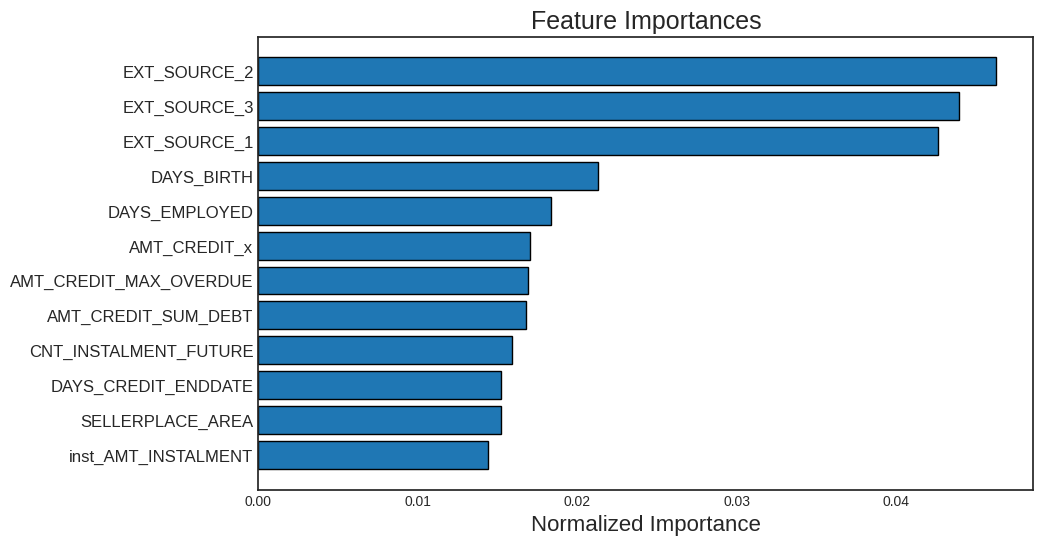

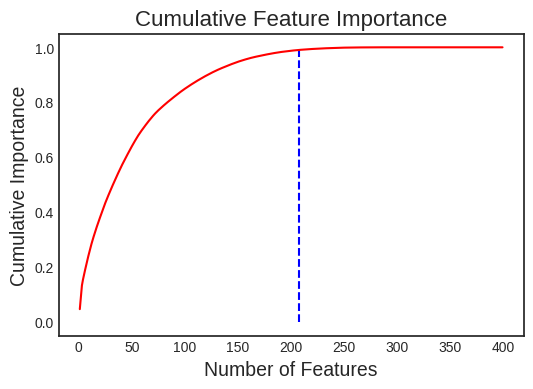

207 features required for 0.99 of cumulative importance


In [22]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [23]:
fs.identify_low_importance(cumulative_importance = 0.99)

206 features required for cumulative importance of 0.99 after one hot encoding.
193 features do not contribute to cumulative importance of 0.99.



In [24]:
fs.feature_importances.head(10)

feature  importance  normalized_importance  \
0            EXT_SOURCE_2       121.2               0.046277   
1            EXT_SOURCE_3       115.0               0.043910   
2            EXT_SOURCE_1       111.6               0.042612   
3              DAYS_BIRTH        55.8               0.021306   
4           DAYS_EMPLOYED        48.1               0.018366   
5            AMT_CREDIT_x        44.6               0.017029   
6  AMT_CREDIT_MAX_OVERDUE        44.3               0.016915   
7     AMT_CREDIT_SUM_DEBT        44.0               0.016800   
8   CNT_INSTALMENT_FUTURE        41.7               0.015922   
9     DAYS_CREDIT_ENDDATE        39.9               0.015235   

   cumulative_importance  
0               0.046277  
1               0.090187  
2               0.132799  
3               0.154105  
4               0.172470  
5               0.189500  
6               0.206415  
7               0.223215  
8               0.239137  
9               0.254372

Training the LGBM model gives us some insights about the data:
* the EXT SOURCE features, which correspond to credit scores are the most important for LGBM

* Quantitative features giving information on credit and installement amounts are also useful 

* Age may also help the estimator to predict better the defaults

In [25]:
#### Removing low feature importance features

features_to_remove = fs.ops['zero_importance'] + fs.ops['low_importance']

features_to_remove = list(set(features_to_remove))


data_v3 = data_v2.drop(features_to_remove, axis = 1)
data_v3.shape

(19680, 206)

## Exploration

### Feature engineering

* Among the most important features according to LGBM is the amount of credit which seems logical


* We also have features that give information about the income of the loaner


* Creating features connecting these informations may be useful for any estimator


* We will create three features:
    * annuity/income
    * annuity/credit
    * income/credit

In [26]:
import numpy as np

data_v4 = data_v3.copy()

data_v4['ANNUITY_on_INCOME_ratio'] = np.where(data_v4['AMT_ANNUITY_x'].notnull() & data_v4['AMT_INCOME_TOTAL'].notnull(), data_v4['AMT_ANNUITY_x']/data_v4['AMT_INCOME_TOTAL'], np.nan)
data_v4['ANNUITY_on_CREDIT_ratio'] = np.where(data_v4['AMT_ANNUITY_x'].notnull() & data_v4['AMT_CREDIT_x'].notnull(), data_v4['AMT_ANNUITY_x']/data_v4['AMT_CREDIT_x'], np.nan)
data_v4['INCOME_on_CREDIT_ratio'] = np.where(data_v4['AMT_INCOME_TOTAL'].notnull() & data_v4['AMT_CREDIT_x'].notnull(), data_v4['AMT_INCOME_TOTAL']/data_v4['AMT_CREDIT_x'], np.nan)

data_v4.shape

(19680, 209)

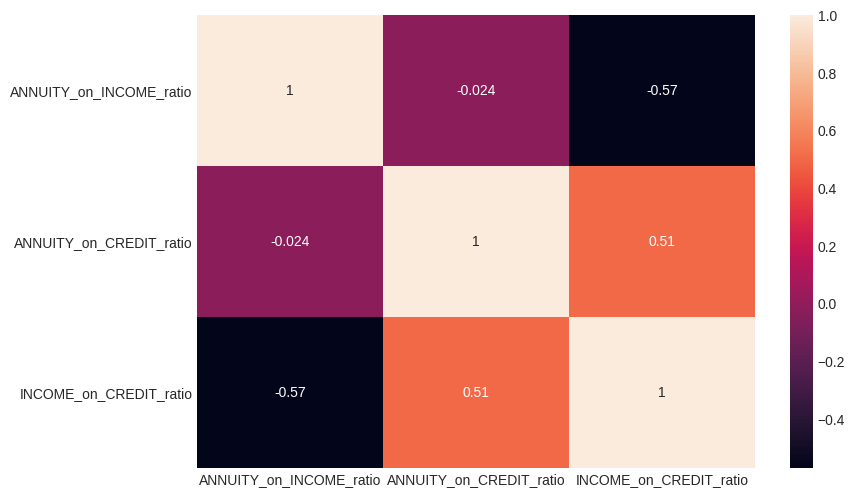

In [27]:
corr_matrix = data_v4[['ANNUITY_on_INCOME_ratio','ANNUITY_on_CREDIT_ratio', 'INCOME_on_CREDIT_ratio']].corr()

fig = plt.figure(figsize = (9,6))

g = fig.add_subplot(111)

g = sns.heatmap(corr_matrix, annot = True)

* There is some linear correlation between some pairs of the created features


* The coefficients are not that close to 1 though so we assume here that each of these features brings a reasonable portion of non redundant information

In [28]:
fs = FeatureSelector(data = data_v4, labels = target)

fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.746325	valid_0's binary_logloss: 0.25009
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.723918	valid_0's binary_logloss: 0.254916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.743759	valid_0's binary_logloss: 0.247712
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's auc: 0.76748	valid_0's binary_logloss: 0.245763
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	valid_0's auc: 0.729013	valid_0's binary_logloss: 0.257143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.728019	valid_0's binary_logloss: 0.255971
T

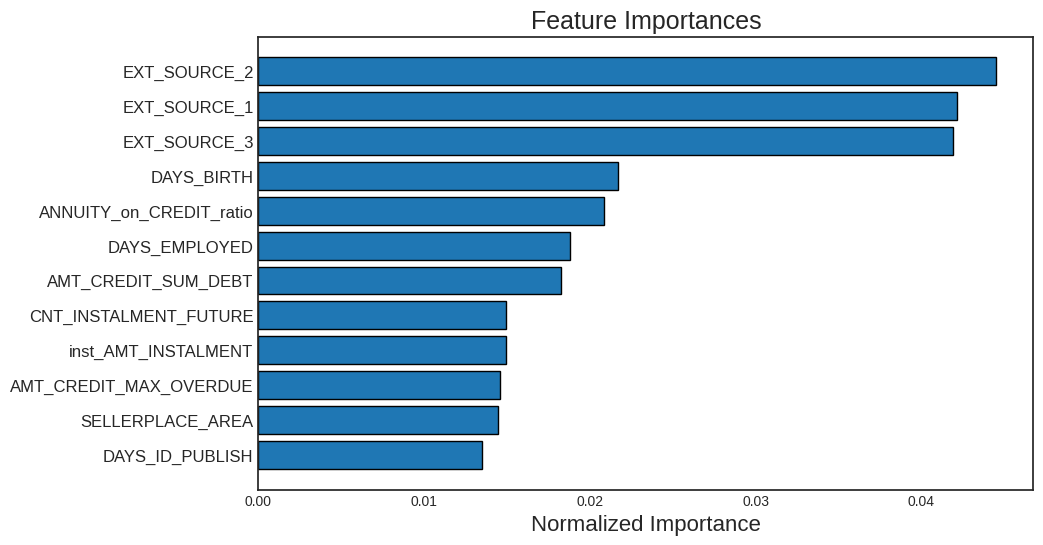

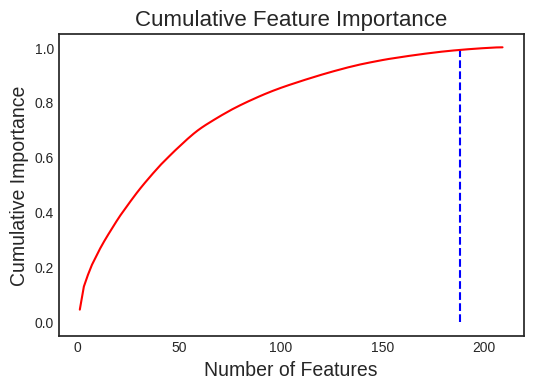

188 features required for 0.99 of cumulative importance


In [29]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

* The engineered annuity/credit ratio feature is among the most important when training the LGBM model


* It confirms our intuition that linking the existing features could help the model to fit better

### Missing values 

* We will perform a last check for missing values in the table to decide to imputing strategy

Nan values ratio within the most 35 important features is 0.1


/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


<AxesSubplot:>

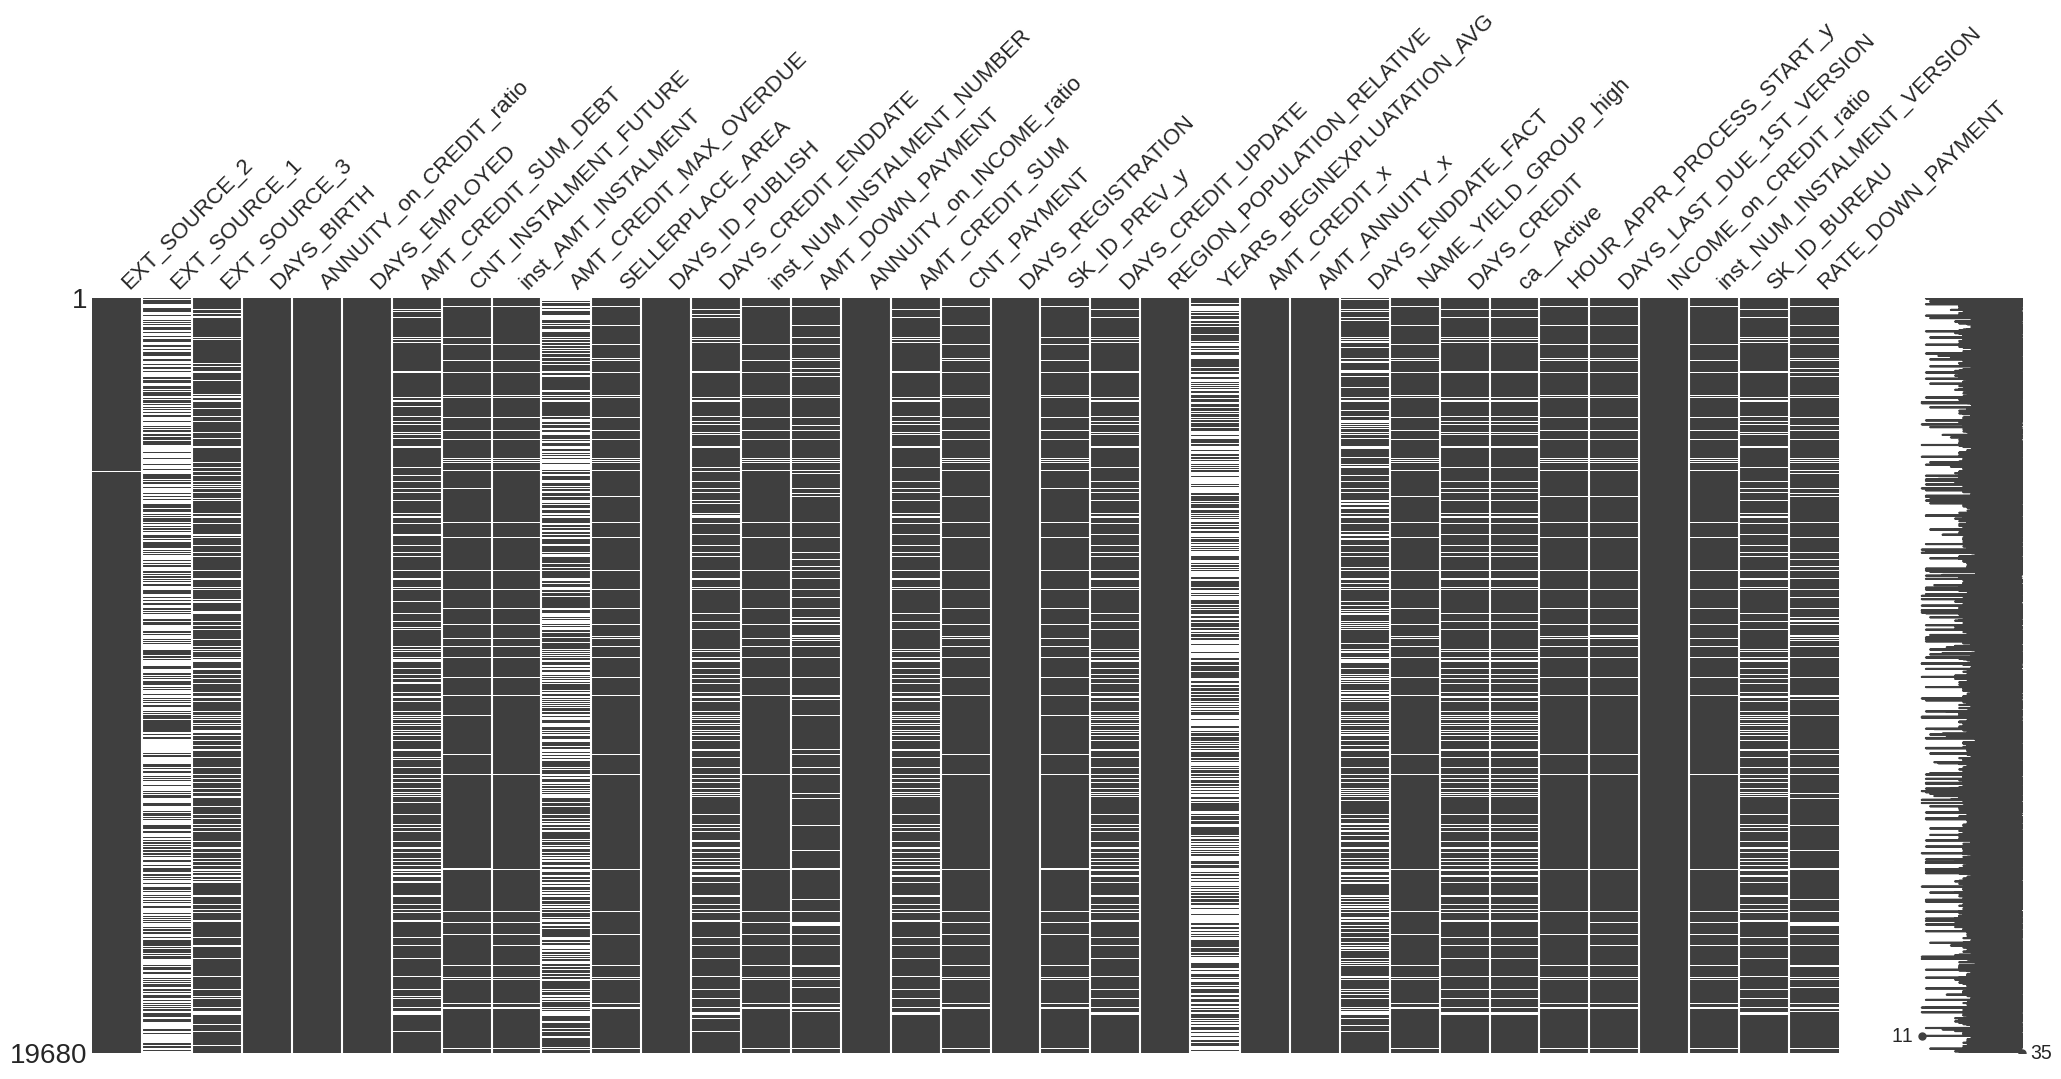

In [30]:
import missingno as msno

# Summary dataframe containing the 35 most important features
df = fs.feature_importances[:35]

most_important_features = df['feature']

### Creating missing values column
df.loc[:,'missing_values'] = [data_v4[feature].isnull().mean() for feature in df['feature']]

print('Nan values ratio within the most 35 important features is ' + str(df['missing_values'].mean().round(decimals = 2)))
msno.matrix(data_v4[most_important_features])

* Percentage of Nan values among the most important features is 11% which is satisfying


* The matrix above shows there are no deficient samples with missing values on majority of most important features


* Naive imputation will be a good choice since it keeps central tendency of the distributions, and given the relatively low proportion of Nans, the distributions distorsion will be reasonable

### Density plots 

* We will now control the distributions of some of the most important features according to LGBM


* These features may also be determining for other estimators 

* Some estimators such as Logistic Regression are really sensitive to outliers. Therefore we would want to work with distributions as close as possible to Gaussian distributions

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

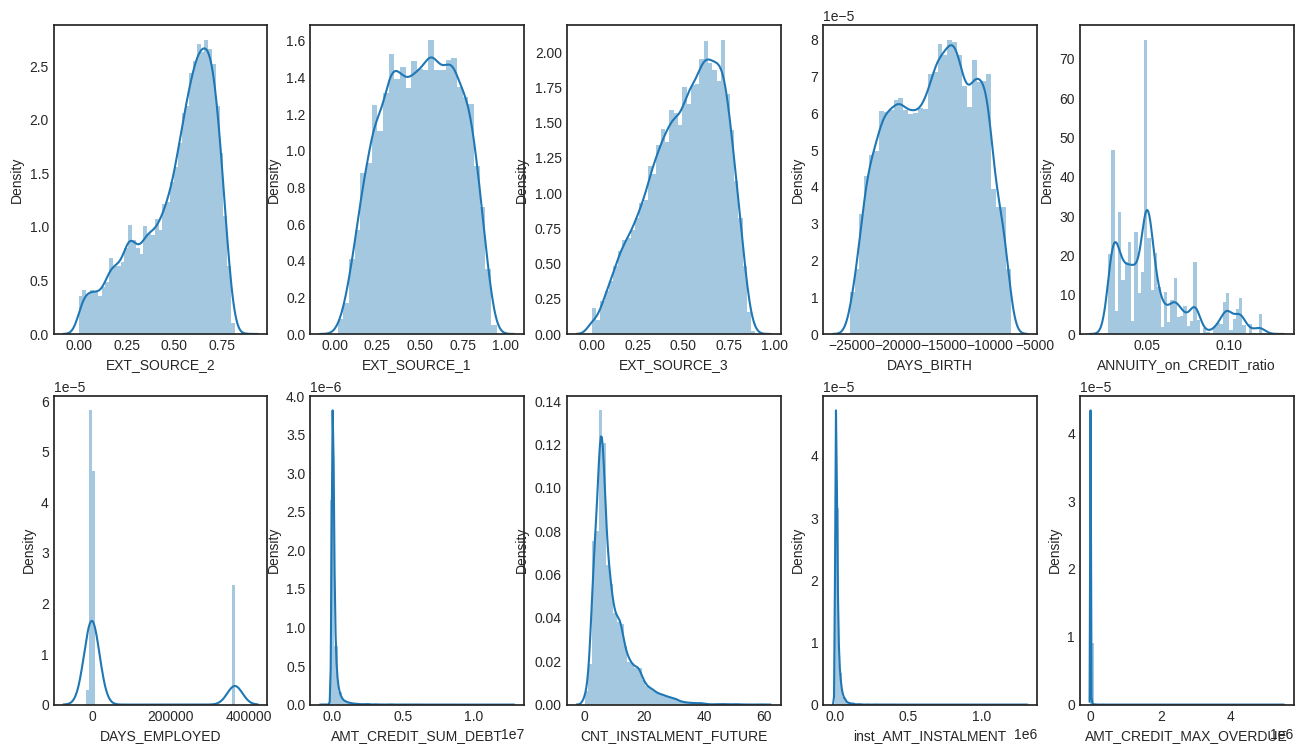

In [31]:
fig = plt.figure(figsize = (16,9))

for i, feature in enumerate(fs.feature_importances['feature'].head(10)):
  g = fig.add_subplot(2, 5, i+1)
  g = sns.distplot(data_v4[feature])


* The majority of distributions do not look Gaussian-like, nor are there unreasonably skewed with strong outliers


* A subset of features do look Gaussian-like which is positive


* We won't perform any transformation on features here (such as log to normalize)

### Features vs target

In [32]:
fig = plt.figure(figsize = (16,9))

for i, feature in enumerate(fs.feature_importances['feature'].head(10)):
  g = fig.add_subplot(2, 5, i+1)
  g = sns.boxplot(data_v4[feature])


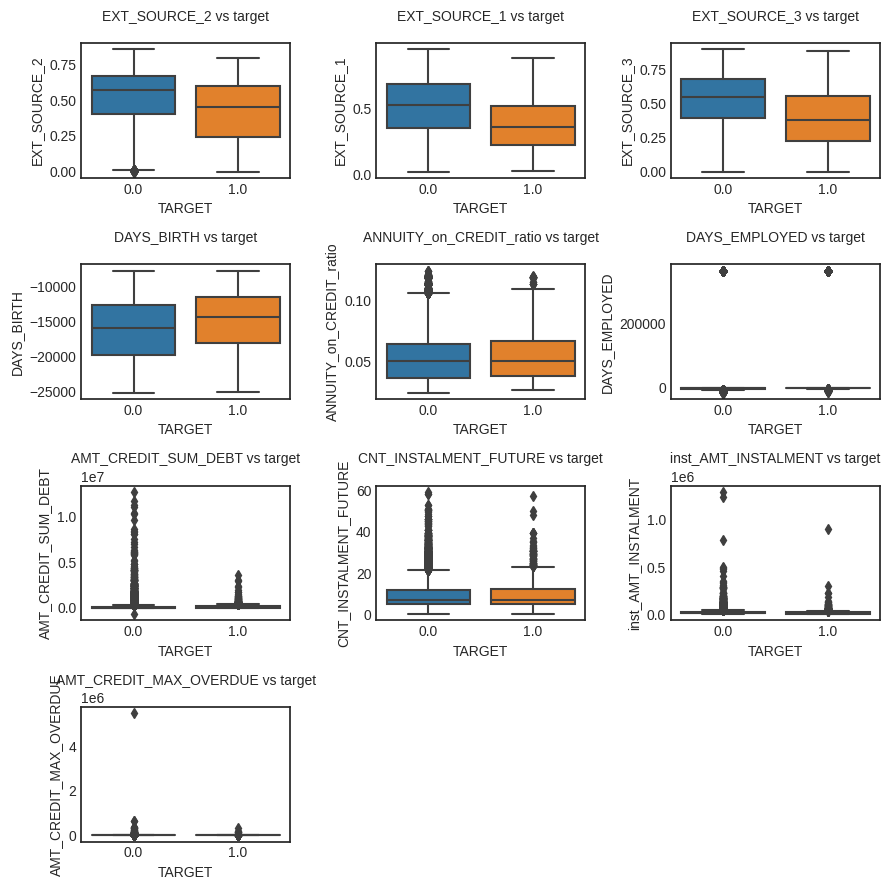

In [178]:
def features_vs_target():
    fig = plt.figure(figsize = (9,9))
    
    important_features = fs.feature_importances['feature'].head(10)
    df = data_v4.loc[:, important_features]
    df = pd.DataFrame(np.column_stack([df, target]), columns = df.columns.tolist() + ['TARGET'], 
                index = data_v4.index)
    
    for i, feature in enumerate(important_features):
        g = fig.add_subplot(4,3,i+1)
        g = sns.boxplot(x = 'TARGET', y = feature, data = df)
        g.set_title(feature + ' vs target', fontsize = 10, pad = 16)
        
    fig.tight_layout()

features_vs_target()

* Clients that default tend to have lower credit scores (EXT source features) than those wo don't


* These plots suggest a degree of dependency between some of the features and the target, which may make them relevant to predict accurately the probability of default of clients

## Modelling

* We will compare in this step the estimators's performance on commonly used metrics for binary classification using Cross-validation method


* Aside the usual metrics, we will create a custom metric that penalizes more a model that would predict false negatives (no default vs actual default) in order to minimize the lending society's risk


* This will be the decisive metric to optimize the model

### Custom metric

* The custom metric takes inspiration on F1-score : harmonic mean of precision & recall


* Since the objective is to minimize the risk of lending to a client that would default, we will consider as metric a weighted harmonic mean giving more weight for recall


* Recall weight  = 5 * precision weight

In [ ]:
### Risk for the bank is to predict false negatives
### Weighted harmonic mean between precision and recall 
### w recall : 5, w precision : 1
from sklearn.metrics import recall_score, precision_score, make_scorer, accuracy_score, f1_score


def custom_metric(y_true, y_pred):
    
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    
    weight_precision = 1
    weight_recall = 5 * weight_precision
    
    if (precision == 0) | (recall == 0):

        score = 0
    
    else:
        
        score = (weight_precision + weight_recall)*(precision*recall)/(weight_recall*precision + recall)
        
    return score


### Pipelines

We will train :
* linear estimators: 
    * logistic regression, support vector machines
    
* non linear estimators :
    * random forest, light gradient boosting
    
* dummy :
    * dummy classifier for the baseline

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier



preprocessor = [('imputer', SimpleImputer(strategy = 'median')), 
            ('scaler', StandardScaler())]


### Dummy

dummy = Pipeline(preprocessor + [('estimator', DummyClassifier(strategy = 'most_frequent', random_state = 42))])


### RandomForest

rf =  Pipeline(preprocessor + [('estimator', RandomForestClassifier(random_state = 42, 
                                                                       class_weight = 'balanced'))])


### Support Vector Machines

svm =  Pipeline(preprocessor + [('estimator', SVC(max_iter = 1000, 
                        class_weight = 'balanced', random_state = 42))])


### Light Gradient Boosting

lgbm = Pipeline(preprocessor + [('estimator', LGBMClassifier(random_state = 42, 
                                                    is_unbalance = True))]) 


### Logistic Regression

log_reg = Pipeline(preprocessor + [('estimator', LogisticRegression(random_state = 42, 
                                                            class_weight = 'balanced', 
                                                    max_iter = 1000))]) 



### Custom metric

* The custom metric takes inspiration on F1-score : harmonic mean of precision & recall


* Since the objective is to minimize the risk of lending to a client that would default, we will consider as metric a weighted harmonic mean giving more weight for recall


* Recall weight  = 5 * precision weight

In [34]:
### Risk for the bank is to predict false negatives
### Weighted harmonic mean between precision and recall 
### w recall : 10, w precision : 1
from sklearn.metrics import recall_score, precision_score, make_scorer, accuracy_score, f1_score


def custom_metric(y_true, y_pred):
    
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    
    weight_precision = 1
    weight_recall = 5 * weight_precision
    
    if (precision == 0) | (recall == 0):

        score = 0
    
    else:
        
        score = (weight_precision + weight_recall)*(precision*recall)/(weight_recall*precision + recall)
        
    return score


### Scores on validation folds

* The evaluation and selection of estimators will be consecutive to two steps:
    * Cross-validation:
        * Their performance on custom metric will be compared on cross-validation folds of non augmented data
        * Their setting will take into account the unbalanced classes
        
    * Augmented data : 
        * SMOTE over sampling
        * Random under & over sampling
        * The performance of the estimators will be measured on custom metric on an untouched validation dataset with actual data
        * Various resampling will be taken into account
      
* We will then select the most performing estimators on the custom metric considering the two approches

In [35]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error 
from sklearn.model_selection import cross_validate

def cross_validation(estimators, data, target, metrics):
    
    data = data.copy()
    
    ### estimator names : estimators parameter takes list-of-tuple as value
    estimators_names = [name for name, estimator in estimators]
    
    ### estimators
    estimators = [estimator for name, estimator in estimators]
    
    ### cv_fold for reproducibility
    cv = StratifiedKFold(n_splits= 5, shuffle = True, random_state=42)
    
    estimators_scores = {}
    ###Performs CV on each estimator
    for i, estimator in enumerate(estimators):
        estimator_scores = cross_validate(estimator = estimator, 
                X = data, y = target, cv = cv, scoring = metrics,
            return_train_score=True)
        
        ### Creates estimator-name key in dictionary and set current estimator scores-dict as value
        estimators_scores[estimators_names[i]] = estimator_scores
        
    
    ### add fit & score time to list of metrics 
    metrics = ['fit_time', 'score_time']  + ['test_' + metric for metric in metrics]
    folds = ['fold_' + str(i+1) for i in range(5)]
    
    fig = plt.figure(figsize = (16,16))
    ### one plot per metric
    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(4,2,i+1)
        
        mean_scores = []
        for j, estimator_name in enumerate(estimators_names):
            
            ### Plots current estimator cv-scores on current metric
            ax.plot(estimators_scores[estimator_name][metric], 
            linestyle = 'dashed', label = estimator_name,
            marker = 'o', markersize = 10)
            
            mean_scores.append(np.mean(estimators_scores[estimator_name][metric]))
            
        ax.set_title(metric, fontsize = 20, pad = 16)
        ax.set_xticks(np.arange(0, 5, 1))
        ax.set_xticklabels(folds)
        
        ### Sort legend according to each estimator mean-score on cv folds on current metric
        handles, labels = ax.get_legend_handles_labels()
        
        handles, labels, score = zip(*sorted(zip(handles, labels, mean_scores), key = lambda k : k[2], 
                                reverse = True))
        
        ax.legend(handles, labels, fontsize = 10, bbox_to_anchor=(0, 1), loc='upper left', ncol=1,
                fancybox=True, framealpha=0.5)
        
    fig.tight_layout()
    
    return estimators_scores
        

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/envs/loan_default/lib

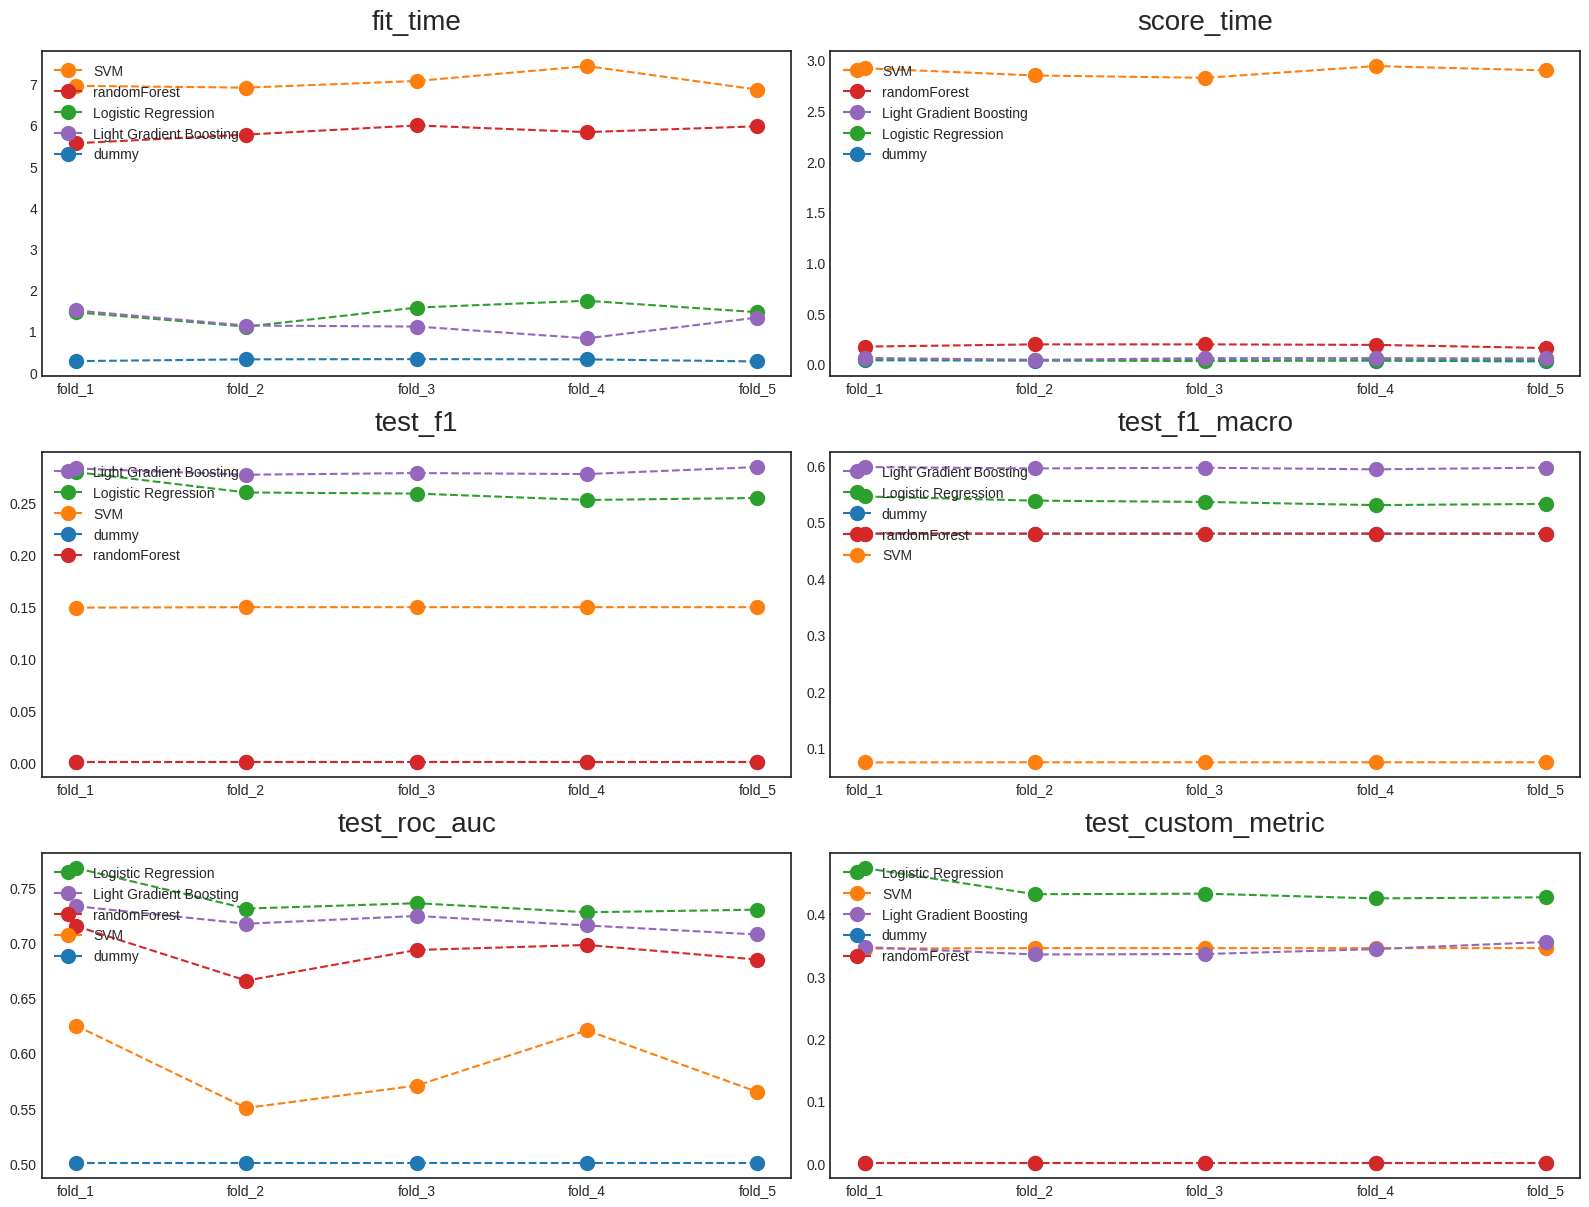

In [36]:
import sklearn.metrics

models = [('dummy', dummy), ('SVM', svm), 
          ('Logistic Regression', log_reg), 
          ('randomForest', rf), 
          ('Light Gradient Boosting', lgbm)]

metrics = {'f1' : sklearn.metrics.SCORERS['f1'],
    'f1_macro' : sklearn.metrics.SCORERS['f1_macro'],
    'roc_auc' : sklearn.metrics.SCORERS['roc_auc']
    , 'custom_metric' : make_scorer(custom_metric)}

estimators_scores = cross_validation(models, data_v4, target, metrics)

* Given the current settings, logistic regression seems to be the most performing estimator accross metrics, with a better overall performance measured by ROC AUC


* This suggests an underlying linear relationship between the features and the target


### CV train/validation scores

* Train/test score comparison for each estimator on metric


* Comparing train/test scores gives insights on whether the estimators are likely to in over-fitting zones

In [37]:
import re
from re import search

def train_test_comparator(estimators_scores, metrics):
    
    
    ### empty df for concatenating in the loop
    df = pd.DataFrame()
    
    for estimator_name in estimators_scores:
        ### Creates df with current estimator scores stored as dict
        estimator_df = pd.DataFrame(estimators_scores[estimator_name])
        ### Creates column filled with estimator name
        estimator_df['model'] = estimator_name
        
        ### concatenate
        df = pd.concat([df,estimator_df])
        
    
    ### melt metric columns into single column
    df = pd.melt(df, id_vars = ['model', 'fit_time', 
            'score_time'], value_vars = df.drop(['model', 'fit_time', 
        'score_time'], axis=1).columns, var_name = 'metric', 
            value_name = 'score')
        
        
    fig = plt.figure(figsize = (16,12))
    
    for i, metric in enumerate(metrics):
        ### Filters dataframe on each metric before plotting
        mask = [bool(re.search(metric, value)) for value in df['metric']]
        filt_df = df[mask]
        
        ### Multiplies by (-1) the score values for 'neg' metrics 
        #neg_mask = [bool(re.search('neg', value)) for value in filt_df['metric']]
        #filt_df.loc[neg_mask, 'score'] = (-1)*filt_df.loc[neg_mask, 'score']
        
        
        g = fig.add_subplot(2,2,i+1)
        g = sns.barplot(x = 'model', y = 'score', hue = 'metric', 
            data = filt_df)
        g.set_title(metric, fontsize = 16, pad = 16)
        g.legend()
        fig.tight_layout()

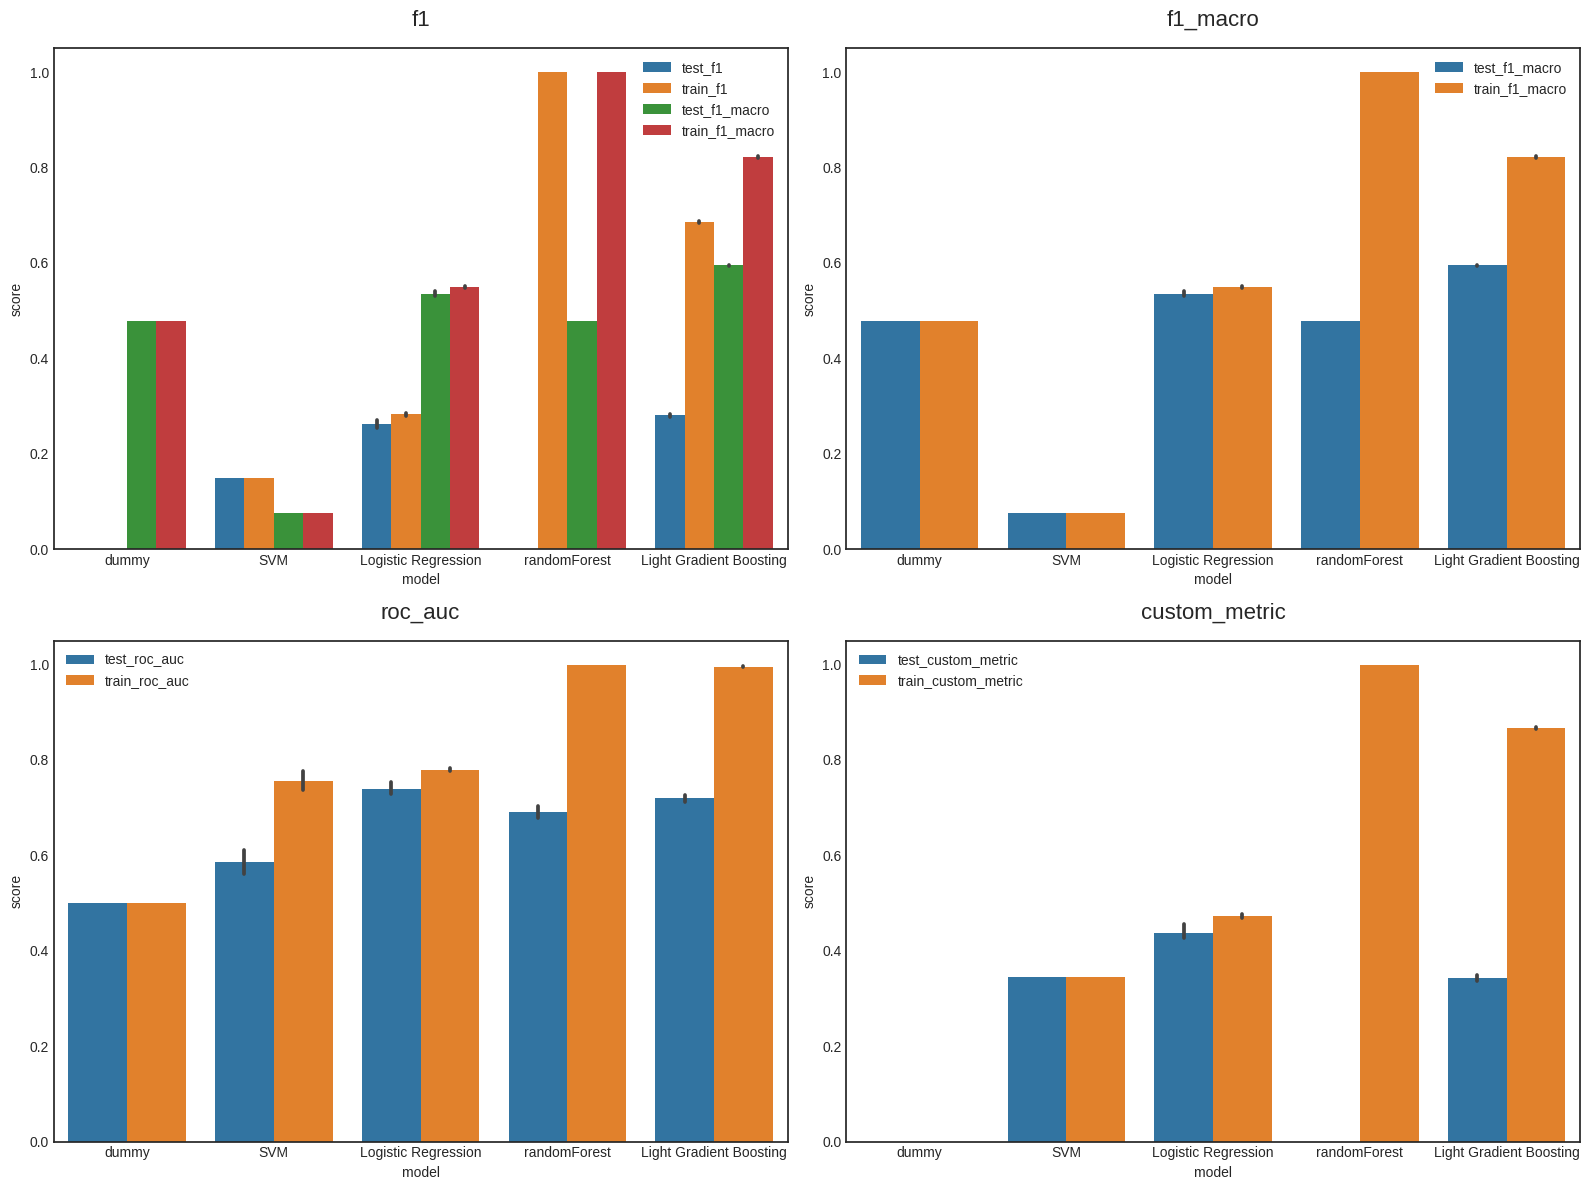

In [38]:
train_test_comparator(estimators_scores, metrics)

* Linear models overfit much less than non linear models


* Ensemble algorithms such as RandomForest or LGBM overfit much more, which suggest their hyper-parameters are not optimal and should be improved

### Data augmentation

* We will now train the estimators on augmented data implementing several techniques:
    * SMOTE over sampling
    * Random Over and Under Sampling
    * train estimators on data resampled with various proportions


* We will reset the settings of the estimators so they do not take into account the unbalanced class weights



In [39]:
from custom_transformers import Selector_transformer, Features_generator

### We need to impute missing values on the train set before resampling
pipe = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                ('scaler', StandardScaler())])

### The steps of the pipeline are performed manually to keep the column labels
### Imputer returns an array without column labels
### We need labels to generate new columns later

X = data_v4.copy()
pipe.fit(X)

imputed_X = X.copy()
imputed_X.loc[:, imputed_X.columns] = pipe.named_steps['imputer'].transform(X)

scaled_X = imputed_X.copy()
scaled_X.loc[:, scaled_X.columns] = pipe.named_steps['scaler'].transform(imputed_X)

### As we want to validation data to be as untouched as possible we will impute missing values
### with imputer fitted on non augmented data
### Keep columns of the train set 
processed_x_valid = x_valid.loc[:,x_valid.columns.isin(data_v4.columns)]

### Generate columns manually
processed_x_valid.loc[:,'ANNUITY_on_INCOME_ratio'] = np.where(processed_x_valid.loc[:,'AMT_ANNUITY_x'].notnull() & processed_x_valid.loc[:,'AMT_INCOME_TOTAL'].notnull(), processed_x_valid.loc[:,'AMT_ANNUITY_x']/processed_x_valid.loc[:,'AMT_INCOME_TOTAL'], np.nan)
processed_x_valid.loc[:,'ANNUITY_on_CREDIT_ratio'] = np.where(processed_x_valid.loc[:,'AMT_ANNUITY_x'].notnull() & processed_x_valid.loc[:,'AMT_CREDIT_x'].notnull(), processed_x_valid.loc[:,'AMT_ANNUITY_x']/processed_x_valid.loc[:,'AMT_CREDIT_x'], np.nan)
processed_x_valid.loc[:,'INCOME_on_CREDIT_ratio'] = np.where(processed_x_valid.loc[:,'AMT_INCOME_TOTAL'].notnull() & processed_x_valid.loc[:,'AMT_CREDIT_x'].notnull(), processed_x_valid.loc[:,'AMT_INCOME_TOTAL']/processed_x_valid.loc[:,'AMT_CREDIT_x'], np.nan)



imputed_x_valid = processed_x_valid.copy()
imputed_x_valid.loc[:, imputed_x_valid.columns] = pipe.named_steps['imputer'].transform(processed_x_valid)

scaled_x_valid = imputed_x_valid.copy()
scaled_x_valid.loc[:,scaled_x_valid.columns] = pipe.named_steps['scaler'].transform(imputed_x_valid)

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [50]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def augmented_scores(models, proportions, X, y, x_valid, y_valid):
    
    fig = plt.figure(figsize = (16,6))
    
    methods = {'SMOTE': SMOTE(random_state = 42), 
              'RandomOverSampler' : RandomOverSampler(random_state = 42),
'RandomUnderSampler': RandomUnderSampler(random_state = 42)}
    
    for i, method in enumerate(methods.keys()):
        ax = fig.add_subplot(1,3,i+1)

        ### Mean score on custom metric for each estimator with current resampling method
        ### Will serve to sort legend for each resampling method-based plot
        mean_scores = []

        for label, model in models:
            
            ### Will stock score on custom metric for each resampling proportion for current estimator
            model_score = []

            for proportion in proportions:
                params = {'sampling_strategy' : proportion}
                resampler = methods[method].set_params(**params)
                augmented_X, augmented_y = resampler.fit_resample(X, y)
                model.fit(augmented_X, augmented_y)
                y_pred = model.predict(x_valid)
                score = custom_metric(y_valid, y_pred)
                model_score.append(score)
            
            mean_scores.append(np.mean(model_score))
            
            ### Plot current estimator scores for each resampling proportion
            ax.plot(model_score, label = label, linestyle = 'dashed', markersize = 10, 
                      marker = 'o')
            
        ax.set_xticks(np.arange(0,len(proportions), 1))
        ax.set_xticklabels(proportions, fontsize = 12)
        ax.set_xlabel('Proportions of minority class', fontsize = 16)
        ax.set_ylabel('Custom score', fontsize = 16)
        ax.set_title(method, fontsize = 16)
        
        ### Sorts legend
        handles, labels  = ax.get_legend_handles_labels()
        handles, labels, mean_scores = zip(*sorted(zip(handles, labels, mean_scores), key = lambda k : k[2], 
                                      reverse = True))
        ax.legend(handles, labels)
    fig.tight_layout()

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

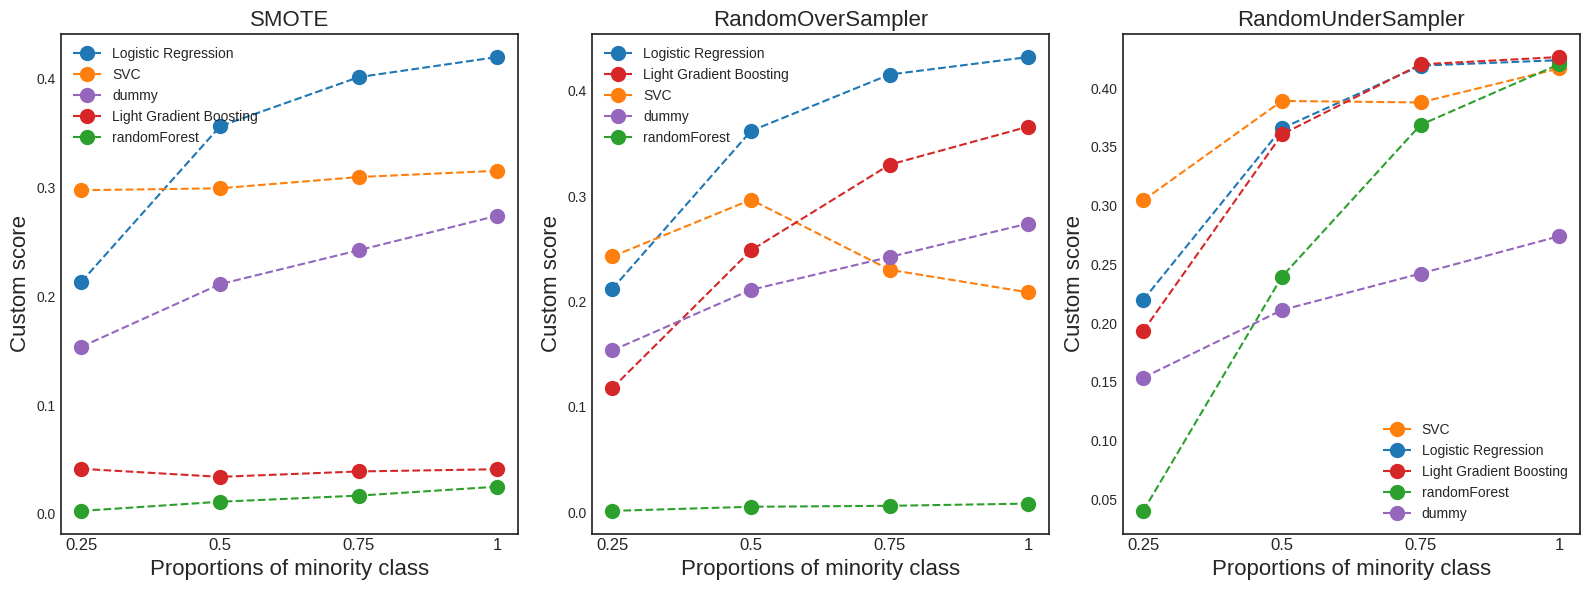

In [52]:
models = [('Logistic Regression', LogisticRegression(random_state = 42, max_iter = 1000)), 
          ('SVC', SVC(random_state=42, max_iter = 1000)), 
          ('randomForest', RandomForestClassifier(random_state=42)), 
          ('Light Gradient Boosting', LGBMClassifier(random_state=42)), 
          ('dummy', DummyClassifier(random_state = 42))]


### Proportions of minority class we will test
proportions = [0.25, 0.5, 0.75, 1]


augmented_scores(models, proportions, scaled_X, target, scaled_x_valid, y_valid) 

* Globally, the performance of the estimators tend to improve as the proportion of minority samples increases, which is logic. Training on more positive samples will have the model predict more positive samples and improve recall



* The performance is also quite variable accross methods



* As when comparing estimators on CV scores, logistic regression seems to be the most performing estimator on this metric. Its performance is very consistent accross methods



* The hierarchy is quite similar. LGBM performs also well. Though its overall performance seems weeker than other estimators, SVM may be a good estimator to predict defaults


* We will optimize these three estimators to select the best

### Optimization

#### CV folds

In [133]:
cv = StratifiedKFold(n_splits= 5, shuffle = True, random_state=42)

#### Logistic Regression

##### Feature selector

* We will introduce a feature selector to see whether the final estimator performs better with a subset of features

In [53]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

### Pipeline with selector
log_reg_with_selector = Pipeline(preprocessor + 
                                 
        [('feature_selector', SelectFromModel(estimator = LogisticRegression(random_state = 42, 
                            max_iter = 1000, class_weight = 'balanced'))), 
         
('estimator', LogisticRegression(max_iter = 1000, random_state = 42, 
                class_weight = 'balanced'))])



# Params
param_grid = {'feature_selector__threshold' : [str(i) + '*median' for i in 
                [0.5, 1, 2, 3, 4, 5, 6]]}


log_grid = GridSearchCV(estimator = log_reg_with_selector,
                   param_grid = param_grid, 
                   scoring = make_scorer(custom_metric), 
                cv = cv)

log_grid.fit(data_v4, target)

print('Optimal parameters are ' + str(log_grid.best_params_))
print('Optimal score is ' + str(log_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['Logistic Regression']['test_custom_metric'])))

Optimal parameters are {'feature_selector__threshold': '0.5*median'}
Optimal score is 0.4385803788164185
Standard score is 0.43797499144879026


* We will keep the selector even though the performance increase is minimal


* We will optimize jointly the following parameters:
    * C : regularization parameter to prevent overfitting
    * penalty : regularization parameter to prevent overfitting as well
    * solver : optimization algorithm

In [54]:
# Parameters

param_grid = [
  {'estimator__penalty': ['l1'], 
   'estimator__solver': ['liblinear', 'saga'], 
   'estimator__C' : [0.001,0.01,0.1,1,10,100]},
  {'estimator__penalty': ['l2'], 
   'estimator__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
   'estimator__C' : [0.001,0.01,0.1,1,10,100]},
 ]

### Grid

log_grid_v2 = GridSearchCV(estimator = log_grid.best_estimator_, 
                        param_grid = param_grid, scoring = make_scorer(custom_metric), 
                        cv = cv)

###Fitting
log_grid_v2.fit(data_v4, target)

print('Optimal parameters are ' + str(log_grid_v2.best_params_))
print('Optimal score is ' + str(log_grid_v2.best_score_))
print('Precedent grid best score is ' + str(log_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['Logistic Regression']['test_custom_metric'])))

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/pyth

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/pyth

Optimal parameters are {'estimator__C': 0.1, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
Optimal score is 0.4410104398385921
Precedent grid best score is 0.4385803788164185
Standard score is 0.43797499144879026


#### LGBM

##### Feature selector 

* We will introduce a feature selector to check whether LGBM performs better on a subset of features

* Tree-based algorithms sometimes perform poorly when the dataset has a high dimensionality and contains noise. All things beinq equal, they are not always able to perform all the potential splits they could on the most relevant features



In [55]:
# Params
lgbm_with_selector = Pipeline(preprocessor + 
        [('feature_selector', SelectFromModel(estimator = LGBMClassifier(random_state = 42,
                                                                        is_unbalance = True))), 
('estimator', LGBMClassifier(random_state = 42, is_unbalance = True))])

param_grid = {'feature_selector__threshold' : [str(i) + '*median' for i in range(1,11)]}


lgbm_grid = GridSearchCV(estimator = lgbm_with_selector, param_grid = param_grid, 
                    scoring = make_scorer(custom_metric), cv = cv)

lgbm_grid.fit(data_v4, target)

print('Optimal parameters are ' + str(lgbm_grid.best_params_))
print('Optimal score is ' + str(lgbm_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['Light Gradient Boosting']['test_custom_metric'])))

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/lightgbm/sklearn.py", line 857, in fit
    callback

Optimal parameters are {'feature_selector__threshold': '7*median'}
Optimal score is 0.363979207090021
Standard score is 0.3433537238988595


##### n_estimators for learning_rate = 0.1

We will first the n_estimators parameter, which is an ensemble-wise parameter. 
* this parameter serves to prevent from overfitting as each tree is trained on its predecessor's errors
* Therefore a number too large of estimators would lead to overfitting, trying to predict essentially noise
* The optimal value for that parameter is dependent of learning_rate, which is here equal to 0.1

In [56]:
# Parameters

param_grid = {'estimator__n_estimators' : range(20,151,10)}

### Grid

lgbm_grid_v2 = GridSearchCV(estimator = lgbm_grid.best_estimator_, 
                param_grid = param_grid, 
            scoring = make_scorer(custom_metric), cv = cv)

###Fitting
lgbm_grid_v2.fit(data_v4, target)


print('Optimal parameters are ' + str(lgbm_grid_v2.best_params_))
print('Optimal score is ' + str(lgbm_grid_v2.best_score_))
print('Precedent grid score is ' + str(lgbm_grid.best_score_))

Optimal parameters are {'estimator__n_estimators': 30}
Optimal score is 0.39292620672374207
Precedent grid score is 0.363979207090021


##### Max_depth, num_leaves & min_data_in_leaf

We will now optimize tree-level paramters.
* max_depth
* min data in leaf
* num leaves
* These HP should be optimized together because the optimal value for one paramter depends on the value of the others.
* We will optimize these paramters with RandomizedSearchCV, which tradeoffs quality of the solution versus computing time.
* However, selecting an optimal number of iterations allows to maximize the probability to reach a global optimum combination. 

In [57]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = [
    {'estimator__max_depth' : [3], 
        'estimator__num_leaves' : [2, 4, 6, 8], 
    'estimator__min_data_in_leaf' : range(100, 1501, 100)},
    
    {'estimator__max_depth' : [5], 
        'estimator__num_leaves' : [int(prop*2**5) for prop in [0.1, 0.25, 0.5, 0.75, 1]], 
    'estimator__min_data_in_leaf' : range(100, 1501, 100)}, 
              
 {'estimator__max_depth' : [7], 
  'estimator__num_leaves' : [int(prop*2**7) for prop in [0.05, 0.1, 0.25, 0.5, 0.75, 1]], 
  'estimator__min_data_in_leaf' : range(100, 1501, 100)}, 
              
 {'estimator__max_depth' : [9], 
  'estimator__num_leaves' : [int(prop*2**9) for prop in [0.05, 0.1, 0.25, 0.5, 0.75, 1]],
'estimator__min_data_in_leaf' : range(100, 1501, 100)}, 
              
 {'estimator__max_depth' : [11], 
  'estimator__num_leaves' : [int(prop*2**11) for prop in [0.05, 0.1, 0.25, 0.5, 0.75, 1]], 
    'estimator__min_data_in_leaf' : range(100, 1501, 100)}, 
    
    {'estimator__max_depth' : [13], 
     'estimator__num_leaves' : [int(prop*2**13) for prop in [0.05, 0.1, 0.25, 0.5, 0.75, 1]], 
    'estimator__min_data_in_leaf' : range(100, 1501, 100)},
              
    {'estimator__max_depth' : [15], 
     'estimator__num_leaves' : [int(prop*2**15) for prop in [0.05, 0.1, 0.25, 0.5, 0.75, 1]], 
    'estimator__min_data_in_leaf' : range(100, 1501, 100)}]

lgbm_grid_v3 = RandomizedSearchCV(lgbm_grid_v2.best_estimator_, 
            param_distributions = param_distributions,
    scoring = make_scorer(custom_metric), cv = cv ,random_state = 42, 
                    n_iter = 60)

lgbm_grid_v3.fit(data_v4, target)

print('Optimal parameters are ' + str(lgbm_grid_v3.best_params_))
print('Optimal score is ' + str(lgbm_grid_v3.best_score_))
print('Precedent grid score is ' + str(lgbm_grid_v2.best_score_))

Optimal parameters are {'estimator__num_leaves': 8192, 'estimator__min_data_in_leaf': 700, 'estimator__max_depth': 13}
Optimal score is 0.4050504421533677
Precedent grid score is 0.39292620672374207


##### Feature fraction & subsamples

We can fix that only a portion of the samples will serve for fitting each tree, as well as a portion of the features. These parameters serve to prevent from overfitting.

In [58]:
# Parameters

param_grid = {'estimator__colsample_bytree' : np.arange(0.2, 1.01, 0.2), 
             'estimator__subsample' : np.arange(0.2, 1.01, 0.2)}

### Grid

lgbm_grid_v4 = GridSearchCV(estimator = lgbm_grid_v3.best_estimator_, 
        param_grid = param_grid, scoring = make_scorer(custom_metric), 
                    cv = cv)

###Fitting
lgbm_grid_v4.fit(data_v4, target)

print('Optimal parameters are ' + str(lgbm_grid_v4.best_params_))
print('Optimal score is ' + str(lgbm_grid_v4.best_score_))
print('Precedent grid score is ' + str(lgbm_grid_v3.best_score_))

Optimal parameters are {'estimator__colsample_bytree': 1.0, 'estimator__subsample': 0.2}
Optimal score is 0.4050504421533677
Precedent grid score is 0.4050504421533677


##### Objective function and boosting

In [59]:
# Parameters

param_grid = {'estimator__objective' : ['binary', 'cross_entropy'], 
              'estimator__boosting' : ['gbdt', 'rf', 'dart', 'goss']}

### Grid

lgbm_grid_v5 = GridSearchCV(estimator = lgbm_grid_v3.best_estimator_, 
                param_grid = param_grid, 
                    scoring = make_scorer(custom_metric), cv = cv)

###Fitting
lgbm_grid_v5.fit(data_v4, target)

print('Optimal parameters are ' + str(lgbm_grid_v5.best_params_))
print('Optimal score is ' + str(lgbm_grid_v5.best_score_))
print('Precedent grid score is ' + str(lgbm_grid_v3.best_score_))

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/anaconda3/envs/loan_default/lib

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/lightgbm/sklearn.py", line 857, in fit
    callbacks=callbacks, init_model=init_model)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/lightgbm/sklearn.py", line 617, in fit
    callbacks=callbacks, init_model=init_model)
  File "/home/marco/anacon

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/lightgbm/sklearn.py", line 857, in fit
    callbacks=callbacks, init_model=init_model)
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/lightgbm/sklearn.py", line 617, in fit
    callbacks=callbacks, init_model=init_model)
  File "/home/marco/anacon

Optimal parameters are {'estimator__boosting': 'gbdt', 'estimator__objective': 'binary'}
Optimal score is 0.4050504421533677
Precedent grid score is 0.4050504421533677


##### Lowering learning_rate

Lowering learning rate can help get more robust models. The n_estimators should be modified proportionally to the decrease of learning_rate.

In [60]:
# Parameters

param_grid = [{'estimator__learning_rate' : [0.01], 'estimator__n_estimators' : [300]}, 
              {'estimator__learning_rate' : [0.02], 'estimator__n_estimators' : [150]},
              {'estimator__learning_rate' : [0.03], 'estimator__n_estimators' : [100]},
              {'estimator__learning_rate' : [0.04], 'estimator__n_estimators' : [75]},
              {'estimator__learning_rate' : [0.05], 'estimator__n_estimators' : [60]}, 
             {'estimator__learning_rate' : [0.06], 'estimator__n_estimators' : [50]}, 
             {'estimator__learning_rate' : [0.07], 'estimator__n_estimators' : [43]}, 
             {'estimator__learning_rate' : [0.08], 'estimator__n_estimators' : [38]}, 
             {'estimator__learning_rate' : [0.09], 'estimator__n_estimators' : [33]}, 
             {'estimator__learning_rate' : [0.1], 'estimator__n_estimators' : [30]}]
              

### Grid

lgbm_grid_v6 = GridSearchCV(estimator = lgbm_grid_v3.best_estimator_, 
            param_grid = param_grid, 
            scoring = make_scorer(custom_metric), cv = cv)

###Fitting
lgbm_grid_v6.fit(data_v4, target)

print('Optimal parameters are ' + str(lgbm_grid_v6.best_params_))
print('Optimal score is ' + str(lgbm_grid_v6.best_score_))
print('Precedent grid score is ' + str(lgbm_grid_v3.best_score_))

Optimal parameters are {'estimator__learning_rate': 0.06, 'estimator__n_estimators': 83}
Optimal score is 0.40932943165014857
Precedent grid score is 0.4050504421533677


#### SVM

##### Feature selector

* We will introduce a feature selector too

* This requires to set the underlying estimator kernel parameter to 'linear'

In [61]:
# Params
param_grid = {'feature_selector__threshold' : [str(i) + '*median' for i in [0.5, 1, 2, 3, 4, 5, 6]]}

### Pipeline with selector
svm_with_selector = Pipeline(preprocessor + 
        [('feature_selector', SelectFromModel(estimator = SVC(kernel = 'linear', 
                                                random_state = 42, max_iter = 1000, 
                                                    class_weight = 'balanced'))), 
('estimator', SVC(max_iter = 1000, random_state = 42, class_weight = 'balanced'))])


svm_grid = GridSearchCV(estimator = svm_with_selector,
                   param_grid = param_grid, 
                   scoring = make_scorer(custom_metric), 
                cv = cv)

svm_grid.fit(data_v4, target)

print('Optimal parameters are ' + str(svm_grid.best_params_))
print('Optimal score is ' + str(svm_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['SVM']['test_custom_metric'])))

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marco/anaconda3/envs/lo

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marco/anaconda3/envs/lo

Optimal parameters are {'feature_selector__threshold': '0.5*median'}
Optimal score is 0.3451220598638187
Standard score is 0.3451220598638187


/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


We will optimize three hyperparameters for Support Vector Classifier.
* C : regularizatio parameter to prevent overfitting
* Gamma: kernel coefficients for 'rbf', 'sigmoid' and 'poly' transformation
* kernel :  type of transformation applied to the feature space before fitting the support vectors

In [62]:
param_distributions = {'estimator__C' : [0.001, 0.01, 0.1, 1, 10], 
             'estimator__gamma' : [0.001, 0.01, 0.05, 0.1, 1], 
             'estimator__kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

svm_grid = RandomizedSearchCV(estimator = svm, param_distributions= 
                            param_distributions, cv= cv, 
                scoring = make_scorer(custom_metric), n_iter = 25, random_state=42)

svm_grid.fit(data_v4, target)

print('Optimal parameters are ' + str(svm_grid.best_params_))
print('Optimal score is ' + str(svm_grid.best_score_))
print('Standard score is ' + str(np.mean(estimators_scores['SVM']['test_custom_metric'])))

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Optimal parameters are {'estimator__kernel': 'sigmoid', 'estimator__gamma': 0.001, 'estimator__C': 10}
Optimal score is 0.3453968480249098
Standard score is 0.3451220598638187


/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


#### Optimized vs non optimized

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Standar

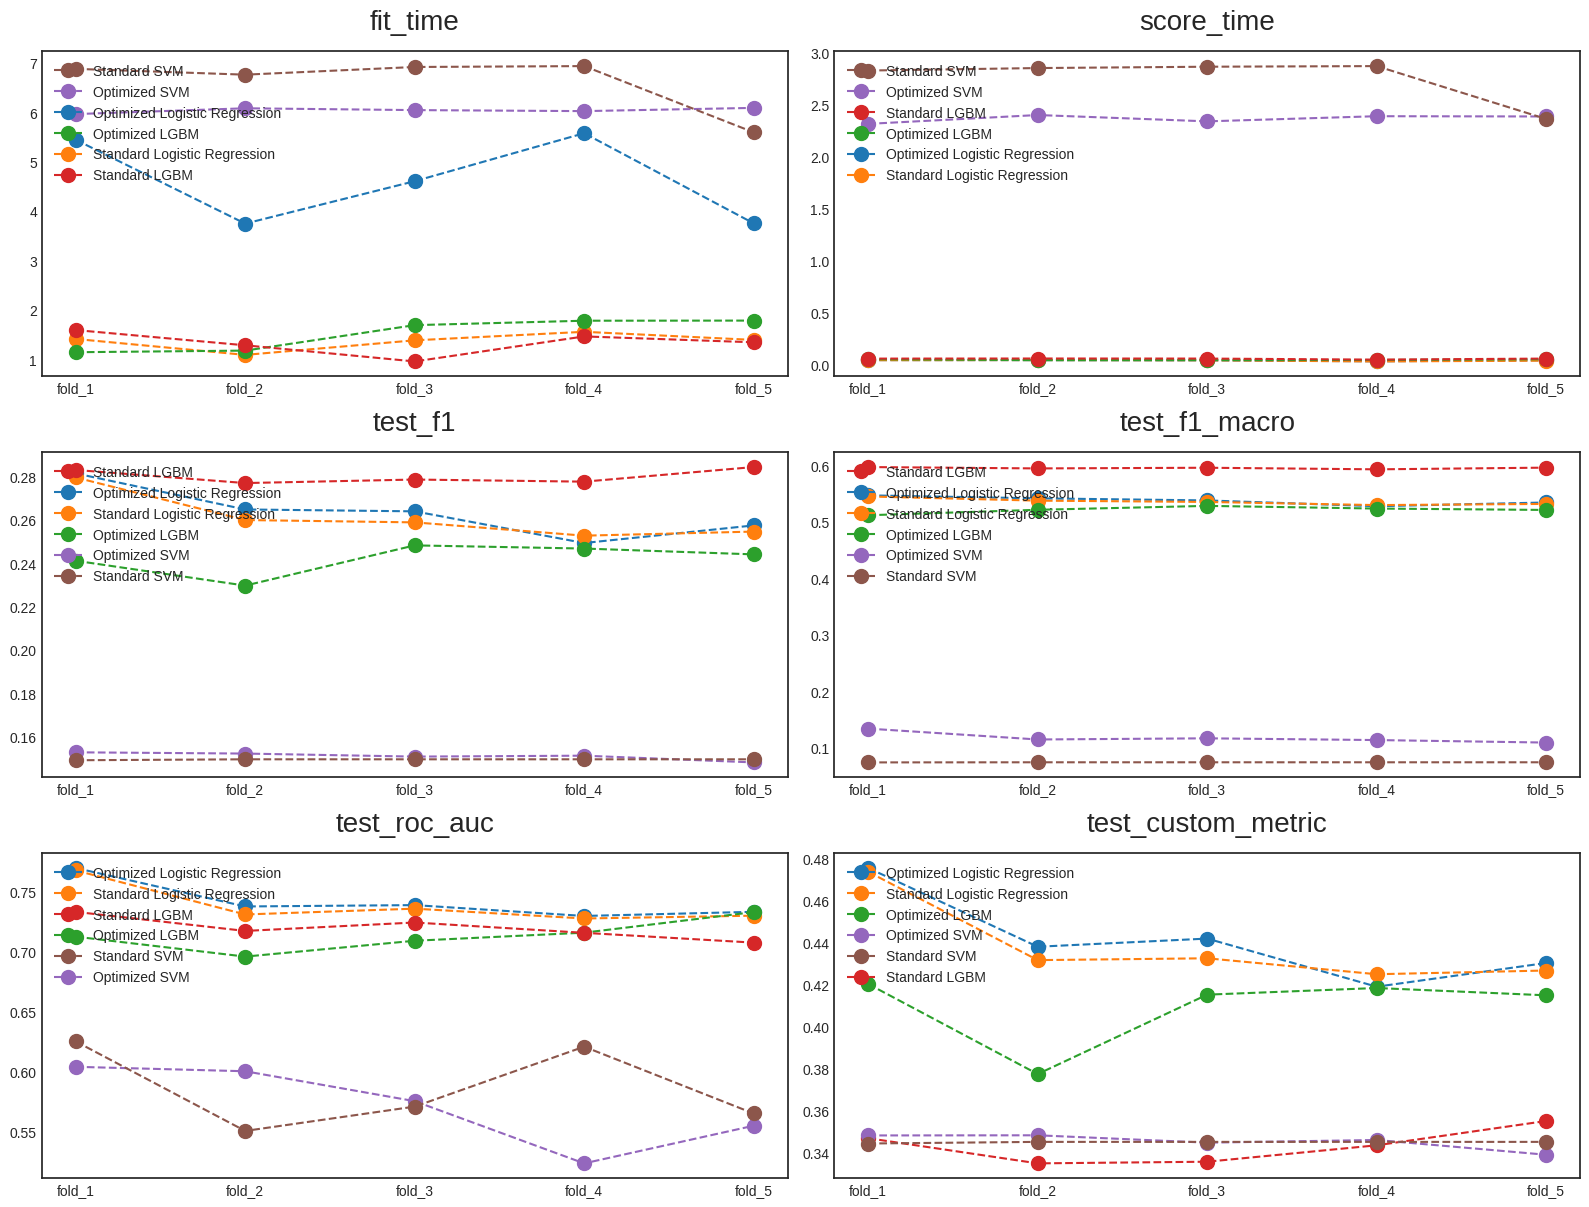

In [63]:
models = [('Optimized Logistic Regression', log_grid_v2.best_estimator_),
          ('Standard Logistic Regression', log_reg), 
          ('Optimized LGBM', lgbm_grid_v6.best_estimator_), 
          ('Standard LGBM', lgbm), 
         ('Optimized SVM', svm_grid.best_estimator_), 
         ('Standard SVM', svm)]

metrics = {'f1' : sklearn.metrics.SCORERS['f1'],
    'roc_auc' : sklearn.metrics.SCORERS['roc_auc']
    , 'custom_metric' : make_scorer(custom_metric)}

optimized_estimators_scores = cross_validation(models, data_v4, target, metrics)

* The optimized version of Logistic Regression is the most performing on the custom metric


* Its overall performance is also the best among tested estimators (ROC AUC)


* Optimization of LGBM improved significantly its score on the custom metric but not its overall performance  

* Our best estimator is the optimized version of logistic regression

#### Train/validation scores for best estimator 

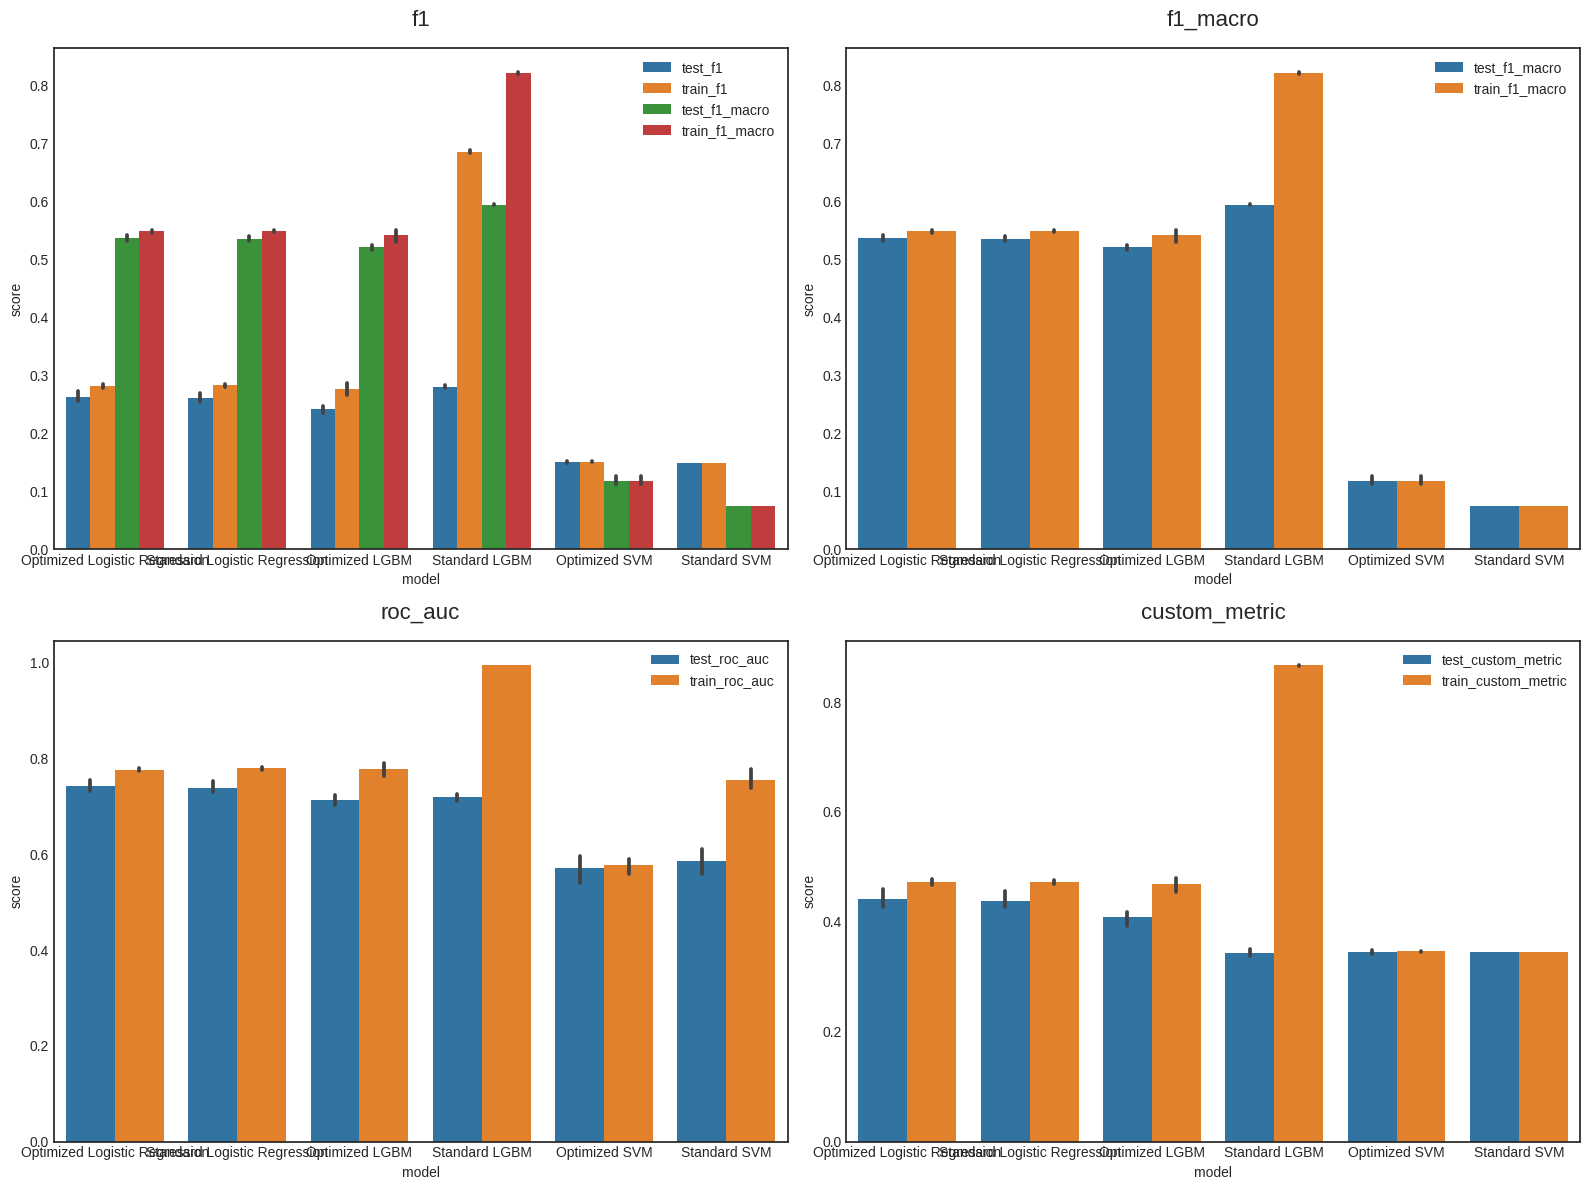

In [64]:
train_test_comparator(optimized_estimators_scores, metrics)

* Interesting to see how optimization significantly reduced LGBM's overfitting

#### Optimal threshold

* The default threshold for predictions is 0.5


* We will try to define an optimal threshold ie which maximises score on custom metric 

* Method : CV 

* The optimal threshold will be the average of optimal thresholds of each cv-fold

In [65]:
from sklearn.model_selection import StratifiedKFold


def find_optimal_threshold(model):
    fig = plt.figure(figsize = (12,9))
    skf = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)
    
    ### we will store optimal threshold for each cv-fold
    optimal_thresholds = []

    ### Generate cross validation folds 
    for i, (train_index, test_index) in enumerate(skf.split(data_v4, target)):
        ax = fig.add_subplot(3, 2, i+1)
        cv_x_train, cv_x_valid = data_v4.iloc[train_index], data_v4.iloc[test_index]
        cv_y_train, cv_y_valid = target.iloc[train_index], target.iloc[test_index]

      ### Fit the best model
        model.fit(cv_x_train, cv_y_train)
        cv_y_pred_proba = model.predict_proba(cv_x_valid)
        custom_scores = []
        recalls = []
        precisions = []

    ### Initialize range of thresholds
        thresholds = np.arange(0,1.02,.02)
        for threshold in thresholds:
            cv_y_pred = np.where(cv_y_pred_proba[:,1] >= threshold, 1, 0)
            custom_score = custom_metric(cv_y_valid, cv_y_pred)
            recall = recall_score(cv_y_valid,cv_y_pred)
            precision = precision_score(cv_y_valid, cv_y_pred)
            custom_scores.append(custom_score)
            recalls.append(recall)
            precisions.append(precision)

        ax.plot(custom_scores, linestyle = 'dashed', marker = 'o', 
          markersize = 5)
        ax.set_xticks(np.arange(0,len(thresholds),1 ))
        ax.set_xticklabels(thresholds.round(decimals = 2), fontsize = 8, rotation = 90)
        ax.set_title('Custom metric vs threshold')
        ax.set_ylabel('Custom metric score', fontsize = 12)
        ax.set_xlabel('Threshold', fontsize = 12)
        ax.set_ylim(-0.05, 1.05)
        
        
        optimal_mask = np.array(custom_scores) == max(custom_scores)
        optimal_threshold = thresholds[optimal_mask]
        optimal_thresholds.append(optimal_threshold)
        ax.axhline(y = max(custom_scores), linestyle = 'dashed', color = 'red')
        ax.axvline(x = np.arange(0,len(thresholds), 1)[optimal_mask][0], linestyle = 'dashed', color = 'blue')
        print('Optimal threshold for fold ', i, ':', str(optimal_threshold[0]), 'custom metric score', str(max(custom_scores)),
      'Recall: ', str(np.array(recalls)[optimal_mask][0]), 'Precision: ', str(np.array(precisions)[optimal_mask][0]))
    print('Optimal threshold is: ', np.mean(optimal_thresholds))
    fig.tight_layout()
    
    optimal_threshold = np.mean(optimal_thresholds)
    
    return optimal_threshold

/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal threshold for fold  0 : 0.48 custom metric score 0.4792013311148086 Recall:  0.7570977917981072 Precision:  0.16901408450704225


/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal threshold for fold  1 : 0.48 custom metric score 0.44300782579108533 Recall:  0.6823899371069182 Precision:  0.1608598962194218


/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal threshold for fold  2 : 0.52 custom metric score 0.44348762109795475 Recall:  0.6477987421383647 Precision:  0.1720969089390142


/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal threshold for fold  3 : 0.46 custom metric score 0.436080467229072 Recall:  0.7044025157232704 Precision:  0.15013404825737264


/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal threshold for fold  4 : 0.38 custom metric score 0.4375353306953081 Recall:  0.8113207547169812 Precision:  0.1324435318275154
Optimal threshold is:  0.46399999999999997


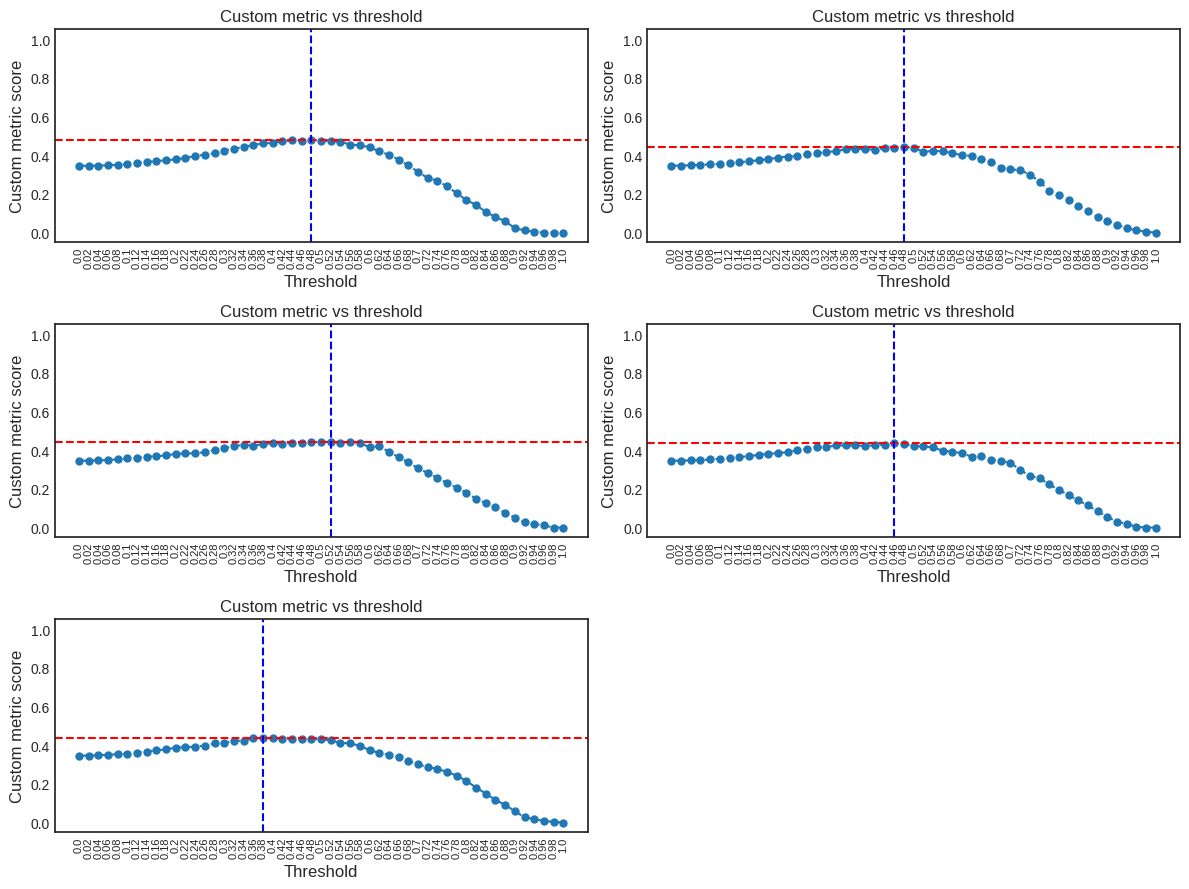

In [66]:
optimal_threshold = find_optimal_threshold(log_grid_v2.best_estimator_)

#### Scores on train/validation sets with optimal threshold

* Compute both train and test scores on cv-folds at optimal threshold


In [67]:
def optimal_scores(model):
    
    skf = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)


    custom_train_scores = []
    custom_validation_scores = []

    ### Generating cross validation splits
    for (train_index, test_index) in skf.split(data_v4, target):
        cv_x_train, cv_x_valid = data_v4.iloc[train_index], data_v4.iloc[test_index]
        cv_y_train, cv_y_valid = target.iloc[train_index], target.iloc[test_index]

      ### Fitting and predictions
        model.fit(cv_x_train, cv_y_train)
        y_proba_valid = model.predict_proba(cv_x_valid)
        y_proba_train = model.predict_proba(cv_x_train)
        y_pred_valid = np.where(y_proba_valid[:,1] >= optimal_threshold, 1,0)
        y_pred_train = np.where(y_proba_train[:,1] >= optimal_threshold, 1,0)
        valid_score = custom_metric(cv_y_valid, y_pred_valid)
        train_score = custom_metric(cv_y_train, y_pred_train)
        custom_validation_scores.append(valid_score)
        custom_train_scores.append(train_score)

    print('score on train', str(np.mean(custom_train_scores)))
    print('score on validation sets', str(np.mean(custom_validation_scores)))
    train_score_optimal_threshold = np.mean(custom_train_scores)
    valid_score_optimal_threshold = np.mean(custom_validation_scores)
    
    return train_score_optimal_threshold, valid_score_optimal_threshold

In [68]:
train_score_optimal_threshold, valid_score_optimal_threshold = optimal_scores(log_grid_v2.best_estimator_)

score on train 0.47419403224461565
score on validation sets 0.4438218872890841


#### Model definition

* We will define the model as a Pipeline to predict the test samples


* The pipeline contains all transformation steps from raw data to estimator

In [69]:
### Pipeline with best estimator

model = Pipeline([('preprocessor', Selector_transformer()), 
                  
                  ('features_generator', Features_generator()), 

                  ('imputer', SimpleImputer(strategy = 'median')),

                  ('scaler', StandardScaler()),

                  ('feature_selector', SelectFromModel(estimator = log_grid_v2.best_estimator_.named_steps['feature_selector'].get_params()['estimator']).set_params(**log_grid_v2.best_estimator_.named_steps['feature_selector'].get_params())), 
                  
                  ('estimator',LogisticRegression().set_params(**log_grid_v2.best_estimator_.named_steps['estimator'].get_params()))])

#### Predictions on test set

In [70]:
### Fit whole model
model.fit(X_train, y_train)

### Predict probabilities
y_proba = model.predict_proba(X_test)

### Optimal threshold
y_pred = np.where(y_proba[:,1] >= optimal_threshold, 1, 0)
custom_test_score = custom_metric(y_test, y_pred)

print('custom metric score on test set: ', str(custom_test_score))

57 features with greater than 0.60 missing values.

1 features with a single unique value.

37 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	valid_0's auc: 0.775754	valid_0's binary_logloss: 0.241133
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[313]	valid_0's auc: 0.770484	valid_0's binary_logloss: 0.242983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	valid_0's auc: 0.781845	valid_0's binary_logloss: 0.239205
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's auc: 0.774216	valid_0's binary_logloss: 0.241046
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[617]	valid_0's auc: 0.777612	valid_0's binary_logloss: 0.241078
Tra

#### Performance generalization

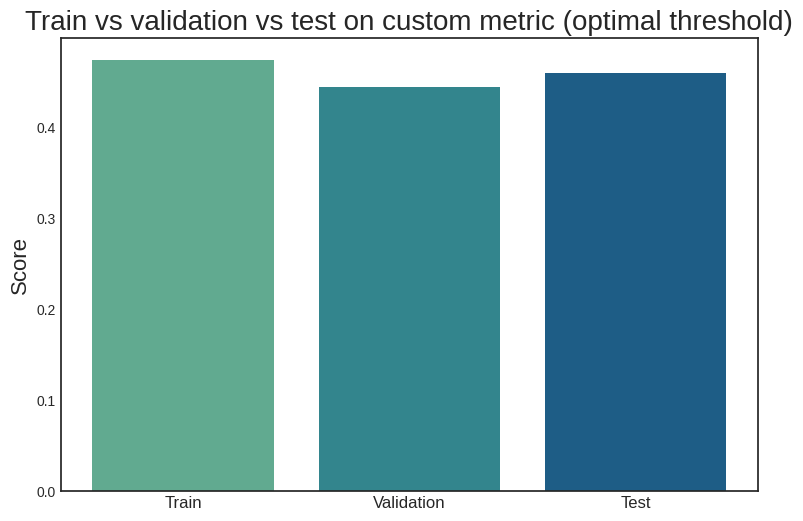

In [71]:
def train_valid_test():
    fig = plt.figure(figsize = (9,6))
    ax = fig.add_subplot(111)

    palette = sns.color_palette("crest",n_colors = 3)
    ax.bar(x = np.arange(0,3,1), 
    height = [train_score_optimal_threshold, valid_score_optimal_threshold,custom_test_score], 
    color = palette)
    ax.set_xticks(np.arange(0,3,1))
    ax.set_xticklabels(['Train', 'Validation', 'Test'], fontsize = 12)
    ax.set_ylabel('Score', fontsize = 16)
    ax.set_title('Train vs validation vs test on custom metric (optimal threshold)', fontsize = 20)

train_valid_test()

* The performance generalizes well


* The score on the test set is slightly higher than the mean score on validation cv-folds

#### Recall and precision

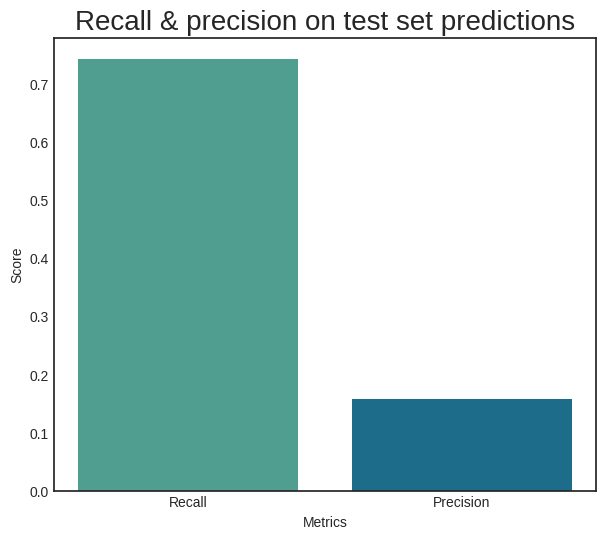

In [72]:

def plot_recall_and_precision():### Predictions with optimal threshold ie highest custom metric score
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    fig = plt.figure(figsize = (7,6))

    ax = fig.add_subplot(111)
    
    palette = sns.color_palette('crest', n_colors = 2)
    ax.bar(x = np.arange(0,2,1), height = [recall, precision], 
        width = 0.8, color = palette)
    ax.set_xticks(np.arange(0,2,1))
    ax.set_xticklabels(['Recall', 'Precision'])
    ax.set_ylabel('Score')
    ax.set_xlabel('Metrics')
    ax.set_title('Recall & precision on test set predictions', fontsize = 20)
    
plot_recall_and_precision()

* The optimization on custom metric favoured models with high recall which was expected

#### Confusion matrix

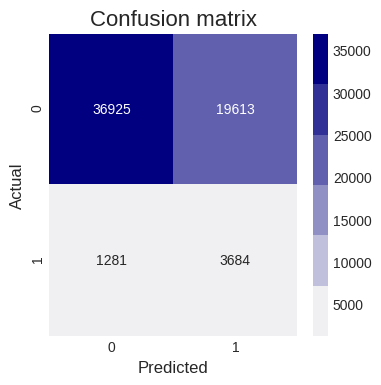

In [73]:
from sklearn.metrics import confusion_matrix

def conf_matrix(y_true,y_pred):
    
    fig = plt.figure(figsize = (4,4))
    g = fig.add_subplot(111)
    
    palette = sns.light_palette("navy")

    matrix = confusion_matrix(y_true,y_pred)
    
    g = sns.heatmap(matrix, annot = True, 
        fmt='2g', annot_kws={"size": 10}, cmap = palette)
    g.set_title('Confusion matrix', fontsize = 16)
    g.set_xlabel('Predicted', fontsize = 12)
    g.set_ylabel('Actual', fontsize = 12)
    
conf_matrix(y_test, y_pred)

### Model interpretability

#### Coefficients

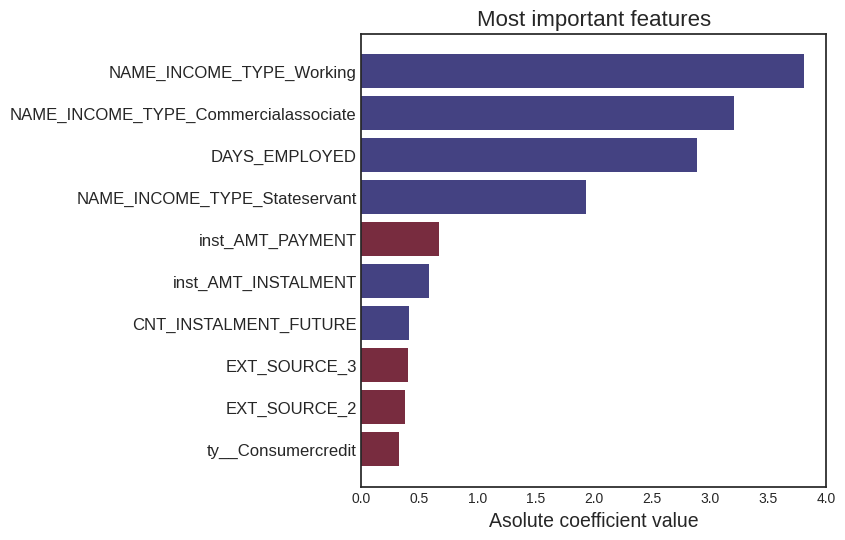

In [94]:
def coef_plot(model, data):
    
    data = data.copy()
    
    data = model.named_steps['preprocessor'].transform(data)
    data = model.named_steps['features_generator'].transform(data)
    data = data.loc[:, model.named_steps['feature_selector'].get_support()]
    
    
    features = data.columns
    coef = model.named_steps['estimator'].coef_.flatten()
    palette = sns.color_palette("icefire", n_colors = 2)
    colors = [palette[0] if coef_ >= 0 else palette[1] for coef_ in coef]
    
    features, coef, colors  = zip(*sorted(zip(features, np.abs(coef), colors), key = lambda k : k[1]))
    
    
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(111)
    ax.barh(y = np.arange(0, 10, 1), 
            width = coef[-10:], color = colors[-10:])
    ax.set_yticks(np.arange(0,10,1))
    ax.set_yticklabels(features[-10:], fontsize = 12)
    ax.set_title('Most important features', fontsize = 16)
    ax.set_xlabel('Absolute coefficient value', fontsize = 14)
    
coef_plot(model, X_train)

* Blue bars represent positive coefficient values, red negative


* High values on EXT SOURCE features tend to reduce probability of default



#### SHAP

* Shapley values are used for model interpretability


* They allow to explain individual predictions

In [96]:
### Fitted estimator 
estimator = model.named_steps['estimator']

### X_train preprocessing for SHAP values
preprocessed_X_train = model.named_steps['preprocessor'].transform(X_train)
preprocessed_X_train = model.named_steps['features_generator'].transform(preprocessed_X_train)

#### Column selection before imputation and scaling to keep actual values of features in X_train
feature_selected_with_actual_values = preprocessed_X_train[
    preprocessed_X_train.columns[model.named_steps['feature_selector'].get_support()]]

### Imputation
imputed_preprocessed_X_train = preprocessed_X_train.copy()
imputed_preprocessed_X_train[imputed_preprocessed_X_train.columns] = model.named_steps['imputer'].transform(preprocessed_X_train)

### Scaling transformation
scaled_preprocessed_X_train = imputed_preprocessed_X_train.copy() 
scaled_preprocessed_X_train[scaled_preprocessed_X_train.columns] = model.named_steps['scaler'].transform(imputed_preprocessed_X_train)

#### Column selection 
#feature_selected_preprocessed_X_train = scaled_preprocessed_X_train.copy()
feature_selected_preprocessed_X_train = scaled_preprocessed_X_train[scaled_preprocessed_X_train.columns[model.named_steps['feature_selector'].get_support()]]


### X_test preprocessing for SHAP values
preprocessed_X_test = model.named_steps['preprocessor'].transform(X_test)
preprocessed_X_test = model.named_steps['features_generator'].transform(preprocessed_X_test)

#### Column selection before imputation and scaling to keep actual values of features
feature_selected_X_test_actual_values = preprocessed_X_test[preprocessed_X_test.columns[model.named_steps['feature_selector'].get_support()]]


### Imputation
imputed_preprocessed_X_test = preprocessed_X_test.copy()
imputed_preprocessed_X_test[imputed_preprocessed_X_test.columns] = model.named_steps['imputer'].transform(preprocessed_X_test)


#### Scaling
scaled_preprocessed_X_test = imputed_preprocessed_X_test.copy() 
scaled_preprocessed_X_test[scaled_preprocessed_X_test.columns] = model.named_steps['scaler'].transform(imputed_preprocessed_X_test)

### Column selection 
feature_selected_preprocessed_X_test = scaled_preprocessed_X_test[scaled_preprocessed_X_test.columns[model.named_steps['feature_selector'].get_support()]]

In [97]:
import shap

explainer = shap.explainers.Linear(estimator, feature_selected_preprocessed_X_train, random_state = 42)
shap_values = explainer.shap_values(feature_selected_preprocessed_X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


##### Summary

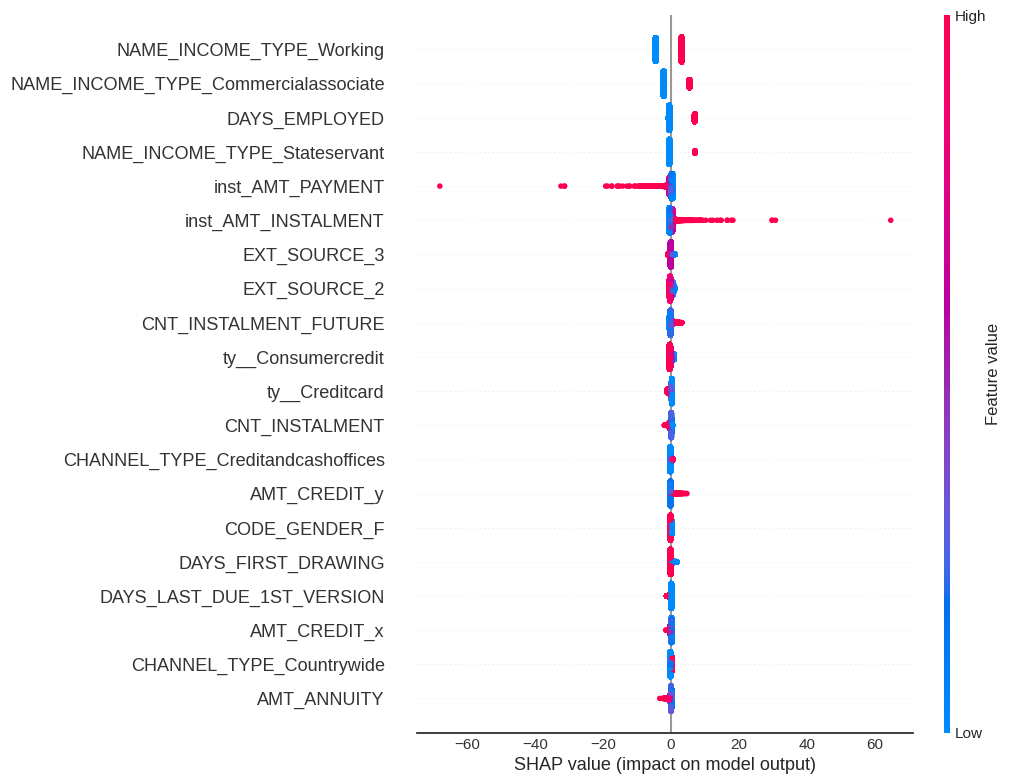

In [98]:
shap.summary_plot(shap_values, feature_selected_preprocessed_X_test, feature_names=feature_selected_preprocessed_X_test.columns)

* We control that the most determining features according to Shapley values match the features with higher absolute coefficients

##### Examples

* Below the explanation plot of an individual prediction


* Shapley values are useful for models which do not allow immediate explanation of predictions, such as non linear models

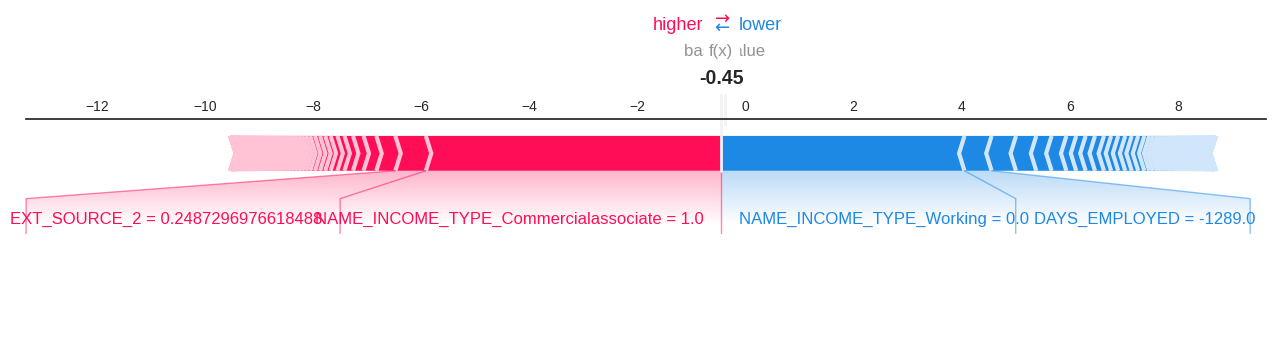

In [160]:
#shap.initjs()

### Number of sample
ind = 43201
shap.plots.force(
    explainer.expected_value, shap_values[ind,:], feature_selected_X_test_actual_values.iloc[ind,:],
    feature_names=feature_selected_preprocessed_X_test.columns, matplotlib = True,
figsize = (16,3))

#### LIME

* LIME is another method for models interpretability

In [156]:
import lime
import lime.lime_tabular

##### Fitting LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(feature_selected_preprocessed_X_train.values,  
mode='classification',training_labels=y_train.values,feature_names=feature_selected_preprocessed_X_train.columns)

In [123]:
#### Computing LIME explainer values for row

i = 43201
lime_values = lime_explainer.explain_instance(feature_selected_preprocessed_X_test.iloc[i,:].values, predict_fn = estimator.predict_proba, num_features=5)

##### Display plot

lime_values.show_in_notebook(show_table = True)


unclosed file <_io.TextIOWrapper name='/home/marco/anaconda3/envs/loan_default/lib/python3.7/site-packages/lime/bundle.js' mode='r' encoding='utf8'>


### Conclusion

* We trained a classifier that predicts loan defaults


* The chosen classifier is an implementation of Logistic Regression


* It was optimized to minimize the risk of granting credit to client that would default


* Prior to estimators selection and optimization we preprocessed the data implementing feature selection principles and creating features


* Further research shall :
    * try other estimators
    * implement feature engineering by creating new features
    * implement a step forward feature selection process to simplify the model
    * implement dimension reduction techniques such as PCA to reduce redundancy among features  

* We will now implement an interactive dashboard and serve the model via an API


### Exporting data and fitted model for dashboard & API

In [124]:
### Exporting data and fiited models for dashboard
import joblib

optimal_threshold_filename = 'Objects/optimal_threshold.bz2'
joblib.dump(optimal_threshold, filename = optimal_threshold_filename, compress = ('bz2', 9))


coef_filename = 'Objects/coef.bz2'
joblib.dump(model.named_steps['estimator'].coef_, filename = coef_filename)


model_filename = 'Objects/model.bz2'
joblib.dump(model, filename=model_filename, compress=('bz2', 9))


X_train_filename = 'Objects/X_train.bz2'
joblib.dump(X_train, filename=X_train_filename, compress=('bz2', 9))


X_test_filename = 'Objects/X_test.bz2'
joblib.dump(X_test, filename=X_test_filename, compress=('bz2', 9))


y_train_filename = 'Objects/y_train.bz2'
joblib.dump(y_train, filename=y_train_filename, compress=('bz2', 9))


explainer_filename = 'Objects/explainer.bz2'
joblib.dump(explainer, filename=explainer_filename, compress=('bz2', 9))


model_features_filename = 'Objects/model_features.bz2'
joblib.dump(feature_selected_X_test_actual_values.columns, filename = model_features_filename, compress = ('bz2', 9))

['Objects/model_features.bz2']